Reserach for:
1) P000M015 Research Project 3 course at Kaunas university of technology, study programme - Applied Mathematics MSc.  
2) Research Council of Lithuania funded student research in their free time “Development and application of machine learning methods in assessing the risk of mortality of prostate cancer patients” (P-ST-22-28). (2022-2023).
  
Project github repo - https://github.com/vytautas9/Tiriamasis_Projektas_3
  
Author:  
Vytautas Kraujalis  
- LinkedIn - https://www.linkedin.com/in/vytautaskraujalis/  
- Email - vytautas.kraujalis2@gmail.com

# References

In [1]:
# Refernces
# https://www.mdpi.com/2072-6694/13/10/2453

# https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html -- paziuret sita
# https://andrewpwheeler.com/2020/09/26/discrete-time-survival-models-in-python/
# https://github.com/apwheele/Blog_Code/blob/master/Python/Discrete_Time/00_PrepData.py
# https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-022-01679-6 -- rimtas sitas


# pasiskaityt, gal i duomenis pridet "Restricted cubic splines function"
# https://towardsdatascience.com/restricted-cubic-splines-c0617b07b9a5
# https://github.com/apwheele/Blog_Code/tree/master/Python/Smooth
# https://andrewpwheeler.com/2020/09/20/making-smoothed-scatterplots-in-python/

# Modules

In [1]:
# Modules
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
from glob import glob
from fnmatch import fnmatch

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from tableone import TableOne # for the descriptive table
from matplotlib import pyplot as plt

# propensity score matching modules
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

# student's t-test
from scipy.stats import ttest_ind

In [2]:
import os

pid = os.getpid()
print("PID: %i" % pid)

n_cpu = os.cpu_count()   # Number of CPUs assigned to this process
print("Number of CPUs in the system:", n_cpu)

# we won't use all the available cpu's for this script 
n_jobs = n_cpu - 2 # The number of tasks to run in parallel

# Control which CPUs are made available for this script
cpu_arg = ''.join([str(ci) + ',' for ci in list(range(n_jobs))])[:-1]
cmd = 'taskset -cp %s %i' % (cpu_arg, pid)
print("executing command '%s' ..." % cmd)
os.system(cmd)

PID: 28316
Number of CPUs in the system: 16
executing command 'taskset -cp 0,1,2,3,4,5,6,7,8,9,10,11,12,13 28316' ...


1

# Functions
Main functions, which will be used later in the project

In [12]:
def read_prepare_initial_data(path):
    # Read, prepare, anonimize the initial data
    df = pd.read_sas(path)
    
    # Select only relevant columns
    df = df[['Amzius', 'PSA', 'naujasCT', 'BxGleason', 'Bxkodas', 'RP_GG', 'pT', 
             'LNI01', 'R', 'PSAdaugiau0_1', 'BCR', 'MTS', 'SURVIVAL', 'OS', 'CSS',
             'Rpgleson', 'TRYSgrupes', 'PLNDO1', 'BFS', 'MTS_men']]
    
    # Create survival column in years
    #df["survival_years"] = df["SURVIVAL"] / 12
    
    # Rename the column names
    df.rename(columns = {'Amzius': 'age', 'PSA': 'psa', 'naujasCT': 'clinical_stage', 
                         'Bxkodas': 'biopsy_gleason_gg', 'RP_GG': 'pathological_gleason_gg',
                         'pT': 'pathologic_stage', 'LNI01': 'lni', 'R': 'surgical_margin_status', 
                         'PSAdaugiau0_1': 'persistent_psa', 'SURVIVAL': 'survival_months', 
                         'BCR': 'bcr', 'MTS': 'mts', 'OS': 'overall_mortality', 
                         'CSS': 'cancer_specific_mortality', 'BFS': 'survival_months_bcr',
                         'MTS_men': 'survival_months_mts'}, 
               inplace = True)
    
    # Fill the LNI column NA values with 'unknown' value
    df.fillna({'lni': 'unknown', 'r': 'unknown'}, inplace = True)
    
    # Drop rows with NA values, every row must have 0 NA values
    df.dropna(thresh=df.shape[1], inplace = True)
    
    # Change the data types of columns
    # Float --> Int --> String
    df[['overall_mortality']] = df[['overall_mortality']].astype(int)
    df[['cancer_specific_mortality']] = df[['cancer_specific_mortality']].astype(int)
    df[['mts']] = df[['mts']].astype(int)
    df[['bcr']] = df[['bcr']].astype(int)
    df[['clinical_stage']] = df[['clinical_stage']].astype(int)
    df[['biopsy_gleason_gg']] = df[['biopsy_gleason_gg']].astype(int)
    df[['pathological_gleason_gg']] = df[['pathological_gleason_gg']].astype(int)
    df[['pathologic_stage']] = df[['pathologic_stage']].astype(int)
    df[['surgical_margin_status']] = df[['surgical_margin_status']].astype(int)
    df[['persistent_psa']] = df[['persistent_psa']].astype(int)
    df[['TRYSgrupes']] = df[['TRYSgrupes']].astype(int)
    df[['PLNDO1']] = df[['PLNDO1']].astype(int)
    
    df = df.astype({'clinical_stage': 'str', 'biopsy_gleason_gg': 'str', 
                    'pathological_gleason_gg': 'str', 'pathologic_stage': 'str',
                    'lni': 'str', 'surgical_margin_status': 'str', 
                    'persistent_psa': 'str', 'bcr': 'str', 'mts': 'str', 
                    'overall_mortality': 'str', 'cancer_specific_mortality': 'str', 
                    'TRYSgrupes': 'str', 'PLNDO1': 'str',
                    'survival_months': 'int32', 'survival_months_bcr': 'int32',
                    'survival_months_mts': 'int32'}) 
    
    # Create death from other causes column
    df['death_from_other_causes'] = '0'
    df.loc[(df['overall_mortality'] == '1') & (df['cancer_specific_mortality'] == '0'), 'death_from_other_causes'] = '1'
    
    # Create a patient ID index
    df['patient_id'] = range(1, len(df) + 1)
    
    return df


# Explodes the provided data based on survival column
def explode_data(df,max_time,min_time=1,time='survival_months',
                 time_discrete='survival_time_discrete',cum_event=False):
    # We create a new time column and clip the data by provided min and max survival times
    df[time_discrete] = df[time].clip(min_time,max_time).apply(range)

    # Exploding the dataset with the created range value in new time column
    data_exploded = df.explode(time_discrete)

    # Reset index
    data_exploded.reset_index(drop=True, inplace=True)

    # New column starts at 0, we'll increase each value by 1
    data_exploded[time_discrete] = pd.to_numeric(data_exploded[time_discrete]) + 1

    # New event column, which will indicate the last event date
    data_exploded['cancer_specific_mortality_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['cancer_specific_mortality'])
    data_exploded['death_from_other_causes_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['death_from_other_causes'])
    data_exploded['mts_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['mts'])
    data_exploded['bcr_discrete'] = (data_exploded[time_discrete] >= data_exploded[time]) * pd.to_numeric(data_exploded['bcr'])
    
    if cum_event == True:
        # Create new event column with duplicated event values from discrete column
        data_exploded['cancer_specific_mortality_cumulative'] = data_exploded['cancer_specific_mortality_discrete']
        data_exploded['death_from_other_causes_cumulative'] = data_exploded['death_from_other_causes_discrete']
        data_exploded['mts_cumulative'] = data_exploded['mts_discrete']
        data_exploded['bcr_cumulative'] = data_exploded['bcr_discrete']
        
        after_survival_time = data_exploded[time_discrete] > data_exploded[time]
        
        # For cumulative events, after end_time we will have NA values, we'll replace those with event indicator
        discrete_column = ['cancer_specific_mortality_discrete', 'death_from_other_causes_discrete', 'mts_discrete', 'bcr_discrete']
        cumulative_column = ['cancer_specific_mortality_cumulative', 'death_from_other_causes_cumulative', 'mts_cumulative', 'bcr_cumulative']
        data_exploded.loc[after_survival_time, discrete_column] = -1
        data_exploded[discrete_column] = data_exploded[discrete_column].replace(-1,np.NaN)
        data_exploded.loc[(after_survival_time & (data_exploded['cancer_specific_mortality']==0)), 'cancer_specific_mortality_cumulative'] = -1
        data_exploded.loc[(after_survival_time & (data_exploded['death_from_other_causes']==0)), 'death_from_other_causes_cumulative'] = -1
        data_exploded.loc[(after_survival_time & (data_exploded['mts']==0)), 'mts_cumulative'] = -1
        data_exploded.loc[(after_survival_time & (data_exploded['bcr']==0)), 'bcr_cumulative'] = -1
        data_exploded[cumulative_column] = data_exploded[cumulative_column].replace(-1,np.NaN)
    return data_exploded


# Create dummy variables, split the data into train and test
def split_and_prepare_data(df, x_columns_to_drop, y_columns):
    
    # Create dummy variables for categorical data
    df = pd.get_dummies(df, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                    'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                    'TRYSgrupes', 'PLNDO1'])
    df_train, df_test, y_train, y_test = train_test_split(
        df.drop(x_columns_to_drop, axis=1),
        df[y_columns], test_size=0.20, random_state=1, stratify=df[['overall_mortality']])
    
    df_train[y_columns] = y_train
    df_test[y_columns] = y_test
    
    return df_train, df_test


# Cumulative hazard based on predicted probabilities, for instant time points.
# Can be grouped by patients
def cumulative_hazard(df, event_probability_column, id_column):
    data_copy = df.copy()
    if id_column is not None:
        data_copy = data_copy[ [id_column, event_probability_column] ]
    else:
        data_copy = data_copy[ [event_probability_column] ]
    data_copy['negative_log_prob'] = np.log( 1 - data_copy[event_probability_column] )
    if id_column is not None:
        data_copy['cumulative_hazard'] = 1 - np.exp(data_copy.groupby(id_column)['negative_log_prob'].transform(pd.Series.cumsum))
    else:
        data_copy['cumulative_hazard'] = 1 - np.exp(data_copy['negative_log_prob'].cumsum())
    return data_copy['cumulative_hazard']


# Train the model based on training data.
# Before training, explode the data with given maximum time and save the model
def train_model(model, df_train, target_column, max_time, min_time=1, x_columns_to_drop=None, is_homogenous_dataset=False):
    df_train_copy = df_train.copy()
    
    # Extract model name
    model_name = type(model).__name__
    print(f'Experiment with {model_name}:')
    print(f'\tStarting fitting a {model_name} model...')
    
    # mts and bcr have different survival months columns
    match target_column:
        case 'mts':
            time = 'survival_months_mts'
        case 'bcr':
            time = 'survival_months_bcr'
        case _:
            time = 'survival_months'
    
    # Explode the dataset
    df_train_copy_exploded = explode_data(df_train_copy, max_time=max_time, time=time)
    
    # Drop columns/targets from feature set
    if x_columns_to_drop is not None:
        X_train = df_train_copy_exploded.drop(x_columns_to_drop, axis=1)
    else:    
        X_train = df_train_copy_exploded.drop(target_column, axis=1)
        
    y_train = df_train_copy_exploded[target_column]
    
    # Fit model to training data
    model.fit(X_train, y_train)
    print(f'\tFinished fitting.')

    # Save model
    if is_homogenous_dataset:
        main_path = 'results/homogenous_data'
    else:
        main_path = 'results/non_homogenous_data'
    model_path = f'{main_path}/{target_column}/{max_time}/{model_name}'
    print(f'\tSaving results to "{model_path}"...')
    # Create directory if does not exist
    Path(model_path).mkdir(parents=True, exist_ok=True)
    
    with open(f'{model_path}/model.sav', 'wb') as f:
        pickle.dump(model, f)
    print(f'\tFinished saving reults.')
    
    return model


# Given non exploded dataset, explode the dataset based on maximum time
# and add predicted instant mortality probabilities and also cumulative.
# Returns exploded dataset with probabilities
def add_predict_probabilities(df, model, max_time, target_column, is_homogenous_dataset=False):
    df_exploded = explode_data(df, max_time=max_time, min_time=max_time, cum_event=True)

    # List of columns names which will be dropped from feature set before predicting outcome
    x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                         'death_from_other_causes', 'cancer_specific_mortality',
                         'death_from_other_causes_discrete', 'mts_discrete',
                         'bcr_discrete', 'cancer_specific_mortality_discrete',
                         'cancer_specific_mortality_cumulative',
                         'death_from_other_causes_cumulative', 'mts_cumulative',
                         'bcr_cumulative', 'survival_months_bcr', 'survival_months_mts']

    X_df = df_exploded.drop(x_columns_to_drop, axis=1)

    # probabilities
    y_pred = model.predict_proba(X_df)[:,1]
    df_exploded['mortality_instant_prob'] = y_pred

    # Cumulative hazard for each patient
    df_exploded['cumulative_hazard'] = cumulative_hazard(df_exploded,'mortality_instant_prob','patient_id')
    
    if is_homogenous_dataset:
        
        # get adjustment parameters
        match target_column:
            case 'cancer_specific_mortality':
                pi_0 = pi_0_csm
                pi_1 = pi_1_csm
                rho_0 = rho_0_csm
                rho_1 = rho_1_csm
            case 'death_from_other_causes':
                pi_0 = pi_0_doc
                pi_1 = pi_1_doc
                rho_0 = rho_0_doc
                rho_1 = rho_1_doc
            case 'mts':
                pi_0 = pi_0_mts
                pi_1 = pi_1_mts
                rho_0 = rho_0_mts
                rho_1 = rho_1_mts
            case 'bcr':
                pi_0 = pi_0_bcr
                pi_1 = pi_1_bcr
                rho_0 = rho_0_bcr
                rho_1 = rho_1_bcr
            case _:
                pi_0 = None
                pi_1 = None
                rho_0 = None
                rho_1 = None
        
        
        # adjusted probabilities
        df_exploded['mortality_instant_prob_adjusted'] = \
            (df_exploded.mortality_instant_prob*(pi_1/rho_1)) / \
            ((1-df_exploded.mortality_instant_prob)*(pi_0/rho_0) + \
             df_exploded.mortality_instant_prob*(pi_1/rho_1))
        
        # Cumulative hazard for each patient (adjusted)
        df_exploded['cumulative_hazard_adjusted'] = cumulative_hazard(df_exploded,'mortality_instant_prob_adjusted','patient_id')
    
    return df_exploded


# Given exploded dataset, id of a patient and a target column plots cumulative and
# instant mortality plots of the given patient
def plot_single_patient(df, patient_id, target_column, target_title='Mortality', fix_axis=True, is_homogenous_dataset=False):
    if patient_id not in df['patient_id'].values:
        print(f'Patient {patient_id} is not in the dataset.')
        return
    
    # Subset of data for the given patient
    person = df[df['patient_id'] == patient_id]
    
    # Get the column indexes of required columns
    mortality_column_index = person.columns.get_loc(target_column)
    survival_column_index = person.columns.get_loc('survival_months')
    max_time_value = person.survival_time_discrete.max()
    
    # Extract model name
    model_name = type(model).__name__
    if is_homogenous_dataset:
        main_path = 'results/homogenous_data'
    else:
        main_path = 'results/non_homogenous_data'
    model_path = f'{main_path}/{target_column + "_discrete"}/{max_time_value}/{model_name}'
    
    # Plot cumulative mortality of the given patient
    fig, ax = plt.subplots()
    if is_homogenous_dataset:
        ax.plot(person['survival_time_discrete'],person['cumulative_hazard_adjusted'],
                alpha=0.6,color='k',drawstyle='steps-post')
    else:
        ax.plot(person['survival_time_discrete'],person['cumulative_hazard'],
                alpha=0.6,color='k',drawstyle='steps-post')
    # Add line when the patient actually died
    if person.iloc[0,mortality_column_index] == '1' and person.iloc[0,survival_column_index] < max_time_value:
        ax.axvline(person.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                   color='red',linewidth=2, zorder=1)
    else:
        ax.axvline(person.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                   color='orange',linewidth=2, zorder=1)
    ax.set_xlabel('Months')
    ax.set_ylabel('Cumulative Probability of ' + target_title)
    if fix_axis:
        ax.set_ylim([0, 1])
    plt.title(f'Patient {person.patient_id.iloc[0]:.0f}')
    plt.savefig(f'{model_path}/cumulative_person_{person.patient_id.iloc[0]}.png', dpi=500, bbox_inches='tight')
    plt.show()

    # Plot instant mortality of the given patient
    fig, ax = plt.subplots()
    if is_homogenous_dataset:
        ax.plot(person['survival_time_discrete'],person['mortality_instant_prob_adjusted'],
                alpha=0.6,color='k')
    else:
        ax.plot(person['survival_time_discrete'],person['mortality_instant_prob'],
                alpha=0.6,color='k')
    # Add line when the patient actually died
    if person.iloc[0,mortality_column_index] == '1' and person.iloc[0,survival_column_index] < max_time_value:
        ax.axvline(person.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                   color='red',linewidth=2, zorder=1)
    else:
        ax.axvline(person.iloc[0,survival_column_index], linestyle='solid', alpha=0.6, 
                   color='orange',linewidth=2, zorder=1)
    ax.set_xlabel('Months')
    ax.set_ylabel('Instant Probability of ' + target_title)
    if fix_axis:
        ax.set_ylim([0, 1])
    plt.title(f'Patient {person.patient_id.iloc[0]:.0f}')
    plt.savefig(f'{model_path}/instant_person_{person.patient_id.iloc[0]}.png', dpi=500, bbox_inches='tight')
    plt.show()


# TODO
def run_experiment(df_train, df_test, model, max_time, target_column, is_homogenous_dataset=False):
    # List of columns names which will be dropped from feature set before fitting the model
    x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                         'death_from_other_causes', 'cancer_specific_mortality',
                         'death_from_other_causes_discrete', 'mts_discrete',
                         'bcr_discrete', 'cancer_specific_mortality_discrete', 
                         'survival_months_bcr', 'survival_months_mts']
    
    model = train_model(model=model, df_train=df_train, target_column=target_column+'_discrete',
                   max_time=max_time, x_columns_to_drop=x_columns_to_drop, 
                        is_homogenous_dataset=is_homogenous_dataset)
    
    # Test on training data
    df_train_predicted = add_predict_probabilities(df_train, model=model, max_time=max_time, 
                                                     target_column=target_column)
    
    # Test on testing data
    df_test_predicted = add_predict_probabilities(df_test, model=model, max_time=max_time, 
                                                    target_column=target_column, 
                                                  is_homogenous_dataset=is_homogenous_dataset)
    
    # AUC for each cumulative slice
    # Months at which we'll check the AUC's
    months = list(range(6, max_time + 6, 6))

    train_auc_stats = []
    test_auc_stats = []
    test_adjusted_auc_stats = []
    for month in months:
        # --- Training data ---
        # Selecting a subset of data based on the months
        select = (df_train_predicted['survival_time_discrete'] == month) & pd.notna(df_train_predicted[target_column+'_cumulative'])
        sub_dat = df_train_predicted[select]

        # If in the sliced data there's a event, calculate AUC metric,
        # otherwise assign NaN value
        if sub_dat[target_column+'_cumulative'].max() == 1:
            fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
            auc_stat = auc(fpr, tpr)
        else:
            auc_stat = float('NaN')
        train_auc_stats.append(auc_stat)

        # --- Testing data ---
        # Selecting a subset of data based on the months
        select = (df_test_predicted['survival_time_discrete'] == month) & pd.notna(df_test_predicted[target_column+'_cumulative'])
        sub_dat = df_test_predicted[select]

        # If in the sliced data there's a event, calculate AUC metric,
        # otherwise assign NaN value
        if sub_dat[target_column+'_cumulative'].max() == 1:
            fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
            auc_stat = auc(fpr, tpr)
        else:
            auc_stat = float('NaN')
        test_auc_stats.append(auc_stat)
        
        # --- Testing adjusted data ---
        if is_homogenous_dataset:
            # Selecting a subset of data based on the months
            select = (df_test_predicted['survival_time_discrete'] == month) & pd.notna(df_test_predicted[target_column+'_cumulative'])
            sub_dat = df_test_predicted[select]

            # If in the sliced data there's a event, calculate AUC metric,
            # otherwise assign NaN value
            if sub_dat[target_column+'_cumulative'].max() == 1:
                fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard_adjusted'])
                auc_stat = auc(fpr, tpr)
            else:
                auc_stat = float('NaN')
            test_adjusted_auc_stats.append(auc_stat)
            

    if is_homogenous_dataset:
        auc_stats = pd.DataFrame(zip(months, train_auc_stats, test_auc_stats, test_adjusted_auc_stats),
                             columns=['month', 'train_auc', 'test_auc', 'test_adjusted_auc'])
    else:
        auc_stats = pd.DataFrame(zip(months, train_auc_stats, test_auc_stats),
                             columns=['month', 'train_auc', 'test_auc'])
    
    
    # Save the auc statistics
    model_name = type(model).__name__
    if is_homogenous_dataset:
        main_path = 'results/homogenous_data'
    else:
        main_path = 'results/non_homogenous_data'
    with open(f'{main_path}/{target_column+"_discrete"}/{max_time}/{model_name}/auc_statistics.pkl', 'wb') as f:
        pickle.dump(auc_stats, f)
    
    
def read_experiment(model_name, target_column, max_time, is_homogenous_dataset=False):
    if is_homogenous_dataset:
        main_path = 'results/homogenous_data'
    else:
        main_path = 'results/non_homogenous_data'
        
    model_path = f'{main_path}/{target_column+"_discrete"}/{max_time}/{model_name}'
        
    # Read model
    with open(f'{model_path}/model.sav', 'rb') as f:
        model = pickle.load(f)
    
    # Read auc statistic
    with open(f'{model_path}/auc_statistics.pkl', 'rb') as f:
        auc_stats = pickle.load(f)
    return model, auc_stats

# Main program

In [13]:
# Read the original data
data_path = 'Data/persistentpsa_3.sas7bdat'
data = read_prepare_initial_data(data_path)
with open('Data/project_3_data_prepared.pkl', 'wb') as f:
    pickle.dump(data, f)

# Read already prepared and saved data
#with open('Data/project_3_data_prepared.pkl', 'rb') as f:
#    data = pickle.load(f)

In [22]:
# Explore the original data
print('Original data shape: ', data.shape)
print('\nSample data:\n', data.head(), '\n')
print(data.describe(), '\n')

# Descriptive statistics
min_max = ['age']
nonnormal = ['age', 'psa', 'BxGleason', 'Rpgleson', 'survival_months', 
             'survival_months_bcr', 'survival_months_mts']
categorical = ['clinical_stage', 'lni', 'biopsy_gleason_gg', 'pathological_gleason_gg',
              'pathologic_stage', 'surgical_margin_status', 'persistent_psa', 'TRYSgrupes',
              'PLNDO1']

# -------------------------
# Overall mortality
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'mts', 'cancer_specific_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'overall_mortality'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
mytable.to_excel(groupby+'.xlsx')
# -------------------------
# Cancer Specific Mortality
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'mts', 'overall_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'cancer_specific_mortality'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
mytable.to_excel(groupby+'.xlsx')
# -------------------------
# Death from other causes
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'mts', 'cancer_specific_mortality', 'overall_mortality']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'death_from_other_causes'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
mytable.to_excel(groupby+'.xlsx')
# -------------------------
# BCR
# -------------------------
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'overall_mortality', 'mts', 'cancer_specific_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'bcr'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
mytable.to_excel(groupby+'.xlsx')
# -------------------------
# MTS
columns = data.columns.tolist()
columns_to_remove = ['patient_id', 'bcr', 'overall_mortality', 'cancer_specific_mortality', 'death_from_other_causes']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'mts'

mytable = TableOne(data, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
mytable.to_excel(groupby+'.xlsx')
# -------------------------


Original data shape:  (1564, 22)

Sample data:
     age    psa clinical_stage  BxGleason biopsy_gleason_gg  \
0  72.0  12.70              2        7.0                 2   
1  66.0   7.59              3        9.0                 5   
2  65.0   7.60              3        7.0                 2   
3  70.0  14.18              3        7.0                 3   
4  57.0   7.86              2        7.0                 3   

  pathological_gleason_gg pathologic_stage  lni surgical_margin_status  \
0                       2                2  1.0                      1   
1                       5                1  1.0                      1   
2                       2                2  1.0                      0   
3                       3                2  1.0                      1   
4                       4                1  1.0                      0   

  persistent_psa  ... survival_months overall_mortality  \
0              0  ...             138                 0   
1              0

|                                     |         | Overall            | 0                  | 1                 |
|-------------------------------------|---------|--------------------|--------------------|-------------------|
| n                                   |         | 1564               | 1350               | 214               |
| Age (years), median [min,max]       |         | 64.0 [40.0,87.0]   | 63.0 [40.0,87.0]   | 68.0 [53.0,78.0]  |
| psa, median [Q1,Q3]                 |         | 6.4 [4.8,9.7]      | 6.3 [4.8,9.5]      | 7.2 [5.2,10.5]    |
| clinical_stage, n (%)               | 1       | 434 (27.7)         | 380 (28.1)         | 54 (25.2)         |
|                                     | 2       | 911 (58.2)         | 783 (58.0)         | 128 (59.8)        |
|                                     | 3       | 219 (14.0)         | 187 (13.9)         | 32 (15.0)         |
| BxGleason, median [Q1,Q3]           |         | 6.0 [6.0,7.0]      | 6.0 [6.0,7.0]      | 6.0 [6.0,7.0

|                                     |         | Overall            | 0                  | 1                 |
|-------------------------------------|---------|--------------------|--------------------|-------------------|
| n                                   |         | 1564               | 1465               | 99                |
| Age (years), median [min,max]       |         | 64.0 [40.0,87.0]   | 64.0 [40.0,87.0]   | 65.0 [48.0,73.0]  |
| psa, median [Q1,Q3]                 |         | 6.4 [4.8,9.7]      | 6.3 [4.8,9.4]      | 8.8 [6.5,14.3]    |
| clinical_stage, n (%)               | 1       | 434 (27.7)         | 426 (29.1)         | 8 (8.1)           |
|                                     | 2       | 911 (58.2)         | 852 (58.2)         | 59 (59.6)         |
|                                     | 3       | 219 (14.0)         | 187 (12.8)         | 32 (32.3)         |
| BxGleason, median [Q1,Q3]           |         | 6.0 [6.0,7.0]      | 6.0 [6.0,7.0]      | 7.0 [6.0,8.0

In [23]:
# Train - test split
x_columns_to_drop = ['bcr', 'mts', 'overall_mortality', 'cancer_specific_mortality', 
                     'death_from_other_causes']
y_columns = ['bcr', 'mts', 'death_from_other_causes', 'cancer_specific_mortality']

data_train, data_test, y_train, y_test = train_test_split(
    data.drop(x_columns_to_drop, axis=1),
    data[y_columns], test_size=0.20, random_state=1, 
    stratify=data[['overall_mortality']])

data_train[y_columns] = y_train
data_test[y_columns] = y_test

## Propensity Score Analysis
We will perform a propensity score matching analysis. Our input is a training dataset and the output will be a smaller dataset which is homogenous based on lymph node status variable (lni).

Doing so, we will lose a lot of patients. This can and will be reflected in the final predictions. To counter that, after making predictions, we'll have to calculate adjusted probabilities.

Propensity score matching is done on binary variables, yet in our case, lni is a 3 level variable. To solve this, propensity score matching will be performed twice.

In [24]:
def students_t_test_control_vs_treatment(control, treatment, alpha = 0.05):
    print(f'Control mean: {control.mean():.3f}\nTreatment mean: {treatment.mean():.3f}')
    
    # compare samples
    _, p = ttest_ind(control, treatment)
    print(f'p = {p:.3f}')
    
    # interpret
    if p > alpha:
        print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
    else:
        print('different distributions/different group mean (reject H0)')

### Propensity score matching for lymph nodes status "Unknown" and "0"
We will firstly perform a matching algorithm between lymph node status "Unknown" and "0"

In [25]:
# Firstly we'll perform propensity score matching on LNI "Unknown and "1"
train_lni_Unknown_0 = data_train.copy()
train_lni_Unknown_0 = train_lni_Unknown_0[train_lni_Unknown_0.lni != '1.0']

# To make things simple, we'll rename values to '0' and '1'
train_lni_Unknown_0['lni'].replace('0.0', '1', inplace=True)
train_lni_Unknown_0['lni'].replace('unknown','0', inplace=True)
print(train_lni_Unknown_0.lni.value_counts(), '\n')

# Get dummies for categorical variables
X_propensity = pd.get_dummies(train_lni_Unknown_0, columns=['clinical_stage', 'pathological_gleason_gg', 
                                                     'biopsy_gleason_gg', 'pathologic_stage', 
                                                     'surgical_margin_status', 'persistent_psa',
                                                     'TRYSgrupes']) 

# Initiate propensity score matching class
psm = PsmPy(X_propensity, treatment='lni', indx='patient_id', 
            exclude = ['cancer_specific_mortality', 'death_from_other_causes', 'mts', 'bcr', 
                       'survival_months', 'PLNDO1'])

# Calculate propensity scores
psm.logistic_ps(balance=False)
#print(psm.predicted_data.head())

# Match patients using propensity logit 
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=1.3)

# plot matching results
#psm.plot_match(Title='Matching Result', Ylabel='# of obs', Xlabel= 'propensity logit', names = ['treatment', 'control'])

# get a list of matched ids
matched_ids = psm.matched_ids[~np.isnan(psm.matched_ids.matched_ID)]
all_ids = pd.concat([matched_ids.patient_id, matched_ids.matched_ID]).values

# select only a subset of data with matched patients
train_lni_Unknown_0_matched = psm.df_matched.query('patient_id in @all_ids')

print('\nBefore matching:\n', train_lni_Unknown_0.lni.value_counts())
print('\nAfter  matching:\n', train_lni_Unknown_0_matched.lni.value_counts())

# student's t-test for numerical variables after matching
print('\nPSA:\n')
students_t_test_control_vs_treatment(control=train_lni_Unknown_0_matched[train_lni_Unknown_0_matched.lni==0].psa, 
                                    treatment=train_lni_Unknown_0_matched[train_lni_Unknown_0_matched.lni==1].psa)
print('\nAge:\n')
students_t_test_control_vs_treatment(control=train_lni_Unknown_0_matched[train_lni_Unknown_0_matched.lni==0].age, 
                                    treatment=train_lni_Unknown_0_matched[train_lni_Unknown_0_matched.lni==1].age)
print('\nBxGleason:\n')
students_t_test_control_vs_treatment(control=train_lni_Unknown_0_matched[train_lni_Unknown_0_matched.lni==0].BxGleason, 
                                    treatment=train_lni_Unknown_0_matched[train_lni_Unknown_0_matched.lni==1].BxGleason)
print('\nRpgleson:\n')
students_t_test_control_vs_treatment(control=train_lni_Unknown_0_matched[train_lni_Unknown_0_matched.lni==0].Rpgleson, 
                                    treatment=train_lni_Unknown_0_matched[train_lni_Unknown_0_matched.lni==1].Rpgleson)

0    766
1    430
Name: lni, dtype: int64 


Before matching:
 0    766
1    430
Name: lni, dtype: int64

After  matching:
 1    282
0    281
Name: lni, dtype: int64

PSA:

Control mean: 8.122
Treatment mean: 8.672
p = 0.127
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)

Age:

Control mean: 63.968
Treatment mean: 64.266
p = 0.578
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)

BxGleason:

Control mean: 6.548
Treatment mean: 6.543
p = 0.924
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)

Rpgleson:

Control mean: 6.868
Treatment mean: 6.851
p = 0.771
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


C:\Users\Vytautas\AppData\Local\Programs\Python\Python310\lib\site-packages\psmpy\psmpy.py:346: UserWarning: Some values do not have a match
  warnings.warn('Some values do not have a match')


### Propensity score matching for lymph nodes status "{Unknown, 0}" and "1"
Now we will perform a matching algorithm between lymph node status {"Unknown", "0"} and "1"

In [26]:
train_lni_1 = data_train.copy()

# Because the previous matched dataset will already have dummy variables, we need to do the same
# for this one at the start
train_lni_1 = pd.get_dummies(train_lni_1, columns=['clinical_stage', 'pathological_gleason_gg', 
                                                   'biopsy_gleason_gg', 'pathologic_stage', 
                                                   'surgical_margin_status', 'persistent_psa',
                                                   'TRYSgrupes']) 

# We need only data for lni == 1 this time.
train_lni_1 = train_lni_1[train_lni_1.lni == '1.0']
train_lni_1['lni'].replace('1.0', '1', inplace=True)
train_lni_1 = train_lni_1.astype({'lni': 'int32'})

# We take the copy of matched dataset
train_lni_Unknown0_1 = train_lni_Unknown_0_matched.copy()
train_lni_Unknown0_1 = train_lni_Unknown0_1.drop(['propensity_score', 'propensity_logit'], axis=1)
train_lni_Unknown0_1.reset_index(inplace=True, drop=True)

# "Unknown" and "0" lni's are both will be replaced with value "0"
train_lni_Unknown0_1['lni'].replace(1, 0, inplace=True)

# We combine matched dataset and dataset where lni == 1
train_lni_Unknown0_1 = pd.concat([train_lni_Unknown0_1, train_lni_1])
print(train_lni_Unknown0_1.lni.value_counts())

psm = PsmPy(train_lni_Unknown0_1, treatment='lni', indx='patient_id', 
            exclude = ['cancer_specific_mortality', 'death_from_other_causes', 'mts', 'bcr', 
                       'survival_months', 'PLNDO1'])

# Calculate propensity scores
psm.logistic_ps(balance=False)
#print(psm.predicted_data.head())

# Match patients using propensity logit 
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=4.9)

# plot matching results
#psm.plot_match(Title='Matching Result', Ylabel='# of obs', Xlabel= 'propensity logit', names = ['treatment', 'control'])

# get a list of matched ids
matched_ids = psm.matched_ids[~np.isnan(psm.matched_ids.matched_ID)]
all_ids = pd.concat([matched_ids.patient_id, matched_ids.matched_ID]).values

# select only a subset of data with matched patients
train_lni_Unknown0_1_matched = psm.df_matched.query('patient_id in @all_ids')

print('\nBefore matching:\n', train_lni_Unknown0_1.lni.value_counts())
print('\nAfter  matching:\n', train_lni_Unknown0_1_matched.lni.value_counts())

# student's t-test for numerical variables after matching
print('\nPSA:\n')
students_t_test_control_vs_treatment(control=train_lni_Unknown0_1_matched[train_lni_Unknown0_1_matched.lni==0].psa, 
                                    treatment=train_lni_Unknown0_1_matched[train_lni_Unknown0_1_matched.lni==1].psa)
print('\nAge:\n')
students_t_test_control_vs_treatment(control=train_lni_Unknown0_1_matched[train_lni_Unknown0_1_matched.lni==0].age, 
                                    treatment=train_lni_Unknown0_1_matched[train_lni_Unknown0_1_matched.lni==1].age)
print('\nBxGleason:\n')
students_t_test_control_vs_treatment(control=train_lni_Unknown0_1_matched[train_lni_Unknown0_1_matched.lni==0].BxGleason, 
                                    treatment=train_lni_Unknown0_1_matched[train_lni_Unknown0_1_matched.lni==1].BxGleason)
print('\nRpgleson:\n')
students_t_test_control_vs_treatment(control=train_lni_Unknown0_1_matched[train_lni_Unknown0_1_matched.lni==0].Rpgleson, 
                                    treatment=train_lni_Unknown0_1_matched[train_lni_Unknown0_1_matched.lni==1].Rpgleson)

0    563
1     55
Name: lni, dtype: int64

Before matching:
 0    563
1     55
Name: lni, dtype: int64

After  matching:
 1    52
0    52
Name: lni, dtype: int64

PSA:

Control mean: 11.622
Treatment mean: 14.362
p = 0.073
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)

Age:

Control mean: 63.865
Treatment mean: 62.942
p = 0.447
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)

BxGleason:

Control mean: 7.058
Treatment mean: 7.423
p = 0.060
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)

Rpgleson:

Control mean: 7.788
Treatment mean: 8.135
p = 0.053
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


C:\Users\Vytautas\AppData\Local\Programs\Python\Python310\lib\site-packages\psmpy\psmpy.py:346: UserWarning: Some values do not have a match
  warnings.warn('Some values do not have a match')


In [27]:
# We want to take a subset of original training dataset based on our matched ids
all_ids = train_lni_Unknown0_1_matched.patient_id.values

# select only a subset of data with matched patients
data_train_homogenous = data_train.query('patient_id in @all_ids')

### Calculating adjustment parameters
Because we selected a subset of training data, later on we will need to adjust predicted probabilities

In [28]:
# N_0_sample - number of patients who did not experience event in homogenous dataset
# N_1_sample - number of patients who experienced event in homogenous dataset
# N_0_population - number of patients who did not experience event in original training dataset
# N_1_population - number of patients who experienced event in original training dataset

# Cancer specific mortality
print('Cancer specific mortality:')
N_0_sample_csm = data_train_homogenous[data_train_homogenous.cancer_specific_mortality == '0'].shape[0]
N_1_sample_csm = data_train_homogenous[data_train_homogenous.cancer_specific_mortality == '1'].shape[0]
rho_0_csm = N_0_sample_csm / (N_0_sample_csm + N_1_sample_csm)
rho_1_csm = 1 - rho_0_csm
print(f'\tN_0_sample: {N_0_sample_csm}, N_1_sample: {N_1_sample_csm}')
print(f'\trho_0: {rho_0_csm:.3f}, rho_1: {rho_1_csm:.3f}')

N_0_population_csm = data_train[data_train.cancer_specific_mortality == '0'].shape[0]
N_1_population_csm = data_train[data_train.cancer_specific_mortality == '1'].shape[0]
pi_0_csm = N_0_population_csm / (N_0_population_csm + N_1_population_csm)
pi_1_csm = 1 - pi_0_csm
print(f'\tN_0_population: {N_0_population_csm}, N_1_population: {N_1_population_csm}')
print(f'\tpi_0: {pi_0_csm:.3f}, pi_1: {pi_1_csm:.3f}')

# Death from other causes
print('\nDeath from other causes:')
N_0_sample_doc = data_train_homogenous[data_train_homogenous.death_from_other_causes == '0'].shape[0]
N_1_sample_doc = data_train_homogenous[data_train_homogenous.death_from_other_causes == '1'].shape[0]
rho_0_doc = N_0_sample_doc / (N_0_sample_doc + N_1_sample_doc)
rho_1_doc = 1 - rho_0_doc
print(f'\tN_0_sample: {N_0_sample_doc}, N_1_sample: {N_1_sample_doc}')
print(f'\trho_0: {rho_0_doc:.3f}, rho_1: {rho_1_doc:.3f}')

N_0_population_doc = data_train[data_train.death_from_other_causes == '0'].shape[0]
N_1_population_doc = data_train[data_train.death_from_other_causes == '1'].shape[0]
pi_0_doc = N_0_population_doc / (N_0_population_doc + N_1_population_doc)
pi_1_doc = 1 - pi_0_doc
print(f'\tN_0_population: {N_0_population_doc}, N_1_population: {N_1_population_doc}')
print(f'\tpi_0: {pi_0_doc:.3f}, pi_1: {pi_1_doc:.3f}')

# MTS
print('\nMTS:')
N_0_sample_mts = data_train_homogenous[data_train_homogenous.mts == '0'].shape[0]
N_1_sample_mts = data_train_homogenous[data_train_homogenous.mts == '1'].shape[0]
rho_0_mts = N_0_sample_mts / (N_0_sample_mts + N_1_sample_mts)
rho_1_mts = 1 - rho_0_mts
print(f'\tN_0_sample: {N_0_sample_mts}, N_1_sample: {N_1_sample_mts}')
print(f'\trho_0: {rho_0_mts:.3f}, rho_1: {rho_1_mts:.3f}')

N_0_population_mts = data_train[data_train.mts == '0'].shape[0]
N_1_population_mts = data_train[data_train.mts == '1'].shape[0]
pi_0_mts = N_0_population_mts / (N_0_population_mts + N_1_population_mts)
pi_1_mts = 1 - pi_0_mts
print(f'\tN_0_population: {N_0_population_mts}, N_1_population: {N_1_population_mts}')
print(f'\tpi_0: {pi_0_mts:.3f}, pi_1: {pi_1_mts:.3f}')

# BCR
print('\nBCR:')
N_0_sample_bcr = data_train_homogenous[data_train_homogenous.bcr == '0'].shape[0]
N_1_sample_bcr = data_train_homogenous[data_train_homogenous.bcr == '1'].shape[0]
rho_0_bcr = N_0_sample_bcr / (N_0_sample_bcr + N_1_sample_bcr)
rho_1_bcr = 1 - rho_0_bcr
print(f'\tN_0_sample: {N_0_sample_bcr}, N_1_sample: {N_1_sample_bcr}')
print(f'\trho_0: {rho_0_bcr:.3f}, rho_1: {rho_1_bcr:.3f}')

N_0_population_bcr = data_train[data_train.bcr == '0'].shape[0]
N_1_population_bcr = data_train[data_train.bcr == '1'].shape[0]
pi_0_bcr = N_0_population_bcr / (N_0_population_bcr + N_1_population_bcr)
pi_1_bcr = 1 - pi_0_bcr
print(f'\tN_0_population: {N_0_population_bcr}, N_1_population: {N_1_population_bcr}')
print(f'\tpi_0: {pi_0_bcr:.3f}, pi_1: {pi_1_bcr:.3f}')

Cancer specific mortality:
	N_0_sample: 87, N_1_sample: 17
	rho_0: 0.837, rho_1: 0.163
	N_0_population: 1209, N_1_population: 42
	pi_0: 0.966, pi_1: 0.034

Death from other causes:
	N_0_sample: 94, N_1_sample: 10
	rho_0: 0.904, rho_1: 0.096
	N_0_population: 1082, N_1_population: 169
	pi_0: 0.865, pi_1: 0.135

MTS:
	N_0_sample: 77, N_1_sample: 27
	rho_0: 0.740, rho_1: 0.260
	N_0_population: 1171, N_1_population: 80
	pi_0: 0.936, pi_1: 0.064

BCR:
	N_0_sample: 20, N_1_sample: 84
	rho_0: 0.192, rho_1: 0.808
	N_0_population: 894, N_1_population: 357
	pi_0: 0.715, pi_1: 0.285


### Train - test dataset overview

#### Based on untransformed split

In [29]:
# -------------------------
# Train (original) - Test
# -------------------------
categorical = ['clinical_stage', 'lni', 'biopsy_gleason_gg', 'pathological_gleason_gg',
              'pathologic_stage', 'surgical_margin_status', 'persistent_psa', 'TRYSgrupes',
              'PLNDO1', 'bcr', 'mts', 'death_from_other_causes', 'cancer_specific_mortality']

temp_train = data_train.copy()
temp_train['split'] = '1_train'

temp_test = data_test.copy()
temp_test['split'] = '2_test'

temp = pd.concat([temp_train, temp_test])
columns = temp.columns.tolist()
columns_to_remove = ['patient_id']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'split'

mytable = TableOne(temp, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
mytable.to_excel('train-test-split-original.xlsx')
# -------------------------

|                                     |         | Overall            | 1_train            | 2_test             |
|-------------------------------------|---------|--------------------|--------------------|--------------------|
| n                                   |         | 1564               | 1251               | 313                |
| Age (years), median [min,max]       |         | 64.0 [40.0,87.0]   | 64.0 [40.0,78.0]   | 63.0 [45.0,87.0]   |
| psa, median [Q1,Q3]                 |         | 6.4 [4.8,9.7]      | 6.5 [4.8,9.7]      | 6.2 [4.8,9.3]      |
| clinical_stage, n (%)               | 1       | 434 (27.7)         | 347 (27.7)         | 87 (27.8)          |
|                                     | 2       | 911 (58.2)         | 729 (58.3)         | 182 (58.1)         |
|                                     | 3       | 219 (14.0)         | 175 (14.0)         | 44 (14.1)          |
| BxGleason, median [Q1,Q3]           |         | 6.0 [6.0,7.0]      | 6.0 [6.0,7.0]      | 6.0 

### Based on homogenous training set

In [30]:
# -------------------------
# Train (homogenous) - Test
# -------------------------
categorical = ['clinical_stage', 'lni', 'biopsy_gleason_gg', 'pathological_gleason_gg',
              'pathologic_stage', 'surgical_margin_status', 'persistent_psa', 'TRYSgrupes',
              'PLNDO1', 'bcr', 'mts', 'death_from_other_causes', 'cancer_specific_mortality']

temp_train = data_train_homogenous.copy()
temp_train['split'] = '1_train_homogenous'

temp_test = data_test.copy()
temp_test['split'] = '2_test'

temp = pd.concat([temp_train, temp_test])
columns = temp.columns.tolist()
columns_to_remove = ['patient_id']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'split'

mytable = TableOne(temp, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
mytable.to_excel('train-test-split-homogenous.xlsx')
# -------------------------

|                                     |         | Overall           | 1_train_homogenous   | 2_test             |
|-------------------------------------|---------|-------------------|----------------------|--------------------|
| n                                   |         | 417               | 104                  | 313                |
| Age (years), median [min,max]       |         | 63.0 [45.0,87.0]  | 65.0 [46.0,76.0]     | 63.0 [45.0,87.0]   |
| psa, median [Q1,Q3]                 |         | 7.0 [5.0,11.5]    | 11.1 [7.0,18.6]      | 6.2 [4.8,9.3]      |
| clinical_stage, n (%)               | 1       | 94 (22.5)         | 7 (6.7)              | 87 (27.8)          |
|                                     | 2       | 234 (56.1)        | 52 (50.0)            | 182 (58.1)         |
|                                     | 3       | 89 (21.3)         | 45 (43.3)            | 44 (14.1)          |
| BxGleason, median [Q1,Q3]           |         | 7.0 [6.0,7.0]     | 7.0 [7.0,8.0]     

In [31]:
# TRYSgrupes column does not have enough data in levels for training data, we'll drop this column
data_train_homogenous.drop(columns=['TRYSgrupes'], inplace=True)

# also adjust testing dataset
data_test_homogenous = data_test.drop(columns=['TRYSgrupes'])

C:\Users\Vytautas\AppData\Local\Temp\ipykernel_28316\3802998703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_homogenous.drop(columns=['TRYSgrupes'], inplace=True)


In [15]:
# -------------------------
# Train (homogenous) - Test
# -------------------------
categorical = ['clinical_stage', 'lni', 'biopsy_gleason_gg', 'pathological_gleason_gg',
              'pathologic_stage', 'surgical_margin_status', 'persistent_psa',
              'PLNDO1', 'bcr', 'mts', 'death_from_other_causes', 'cancer_specific_mortality']

temp_train = data_train_homogenous.copy()
temp_train['split'] = '1_train_homogenous'

temp_test = data_test_homogenous.copy()
temp_test['split'] = '2_test'

temp = pd.concat([temp_train, temp_test])
columns = temp.columns.tolist()
columns_to_remove = ['patient_id']
columns = [column for column in columns if column not in columns_to_remove]
groupby = 'split'

mytable = TableOne(temp, columns=columns, groupby=groupby, nonnormal=nonnormal, 
                   min_max=min_max, missing=False, rename={'age': 'Age (years)'}, 
                   sort=False, categorical=categorical)
print(mytable.tabulate(tablefmt="github"), '\n')
mytable.to_excel('train-test-split-homogenous.xlsx')
# -------------------------

|                                  |         | Overall           | 1_train_homogenous   | 2_test             |
|----------------------------------|---------|-------------------|----------------------|--------------------|
| n                                |         | 415               | 102                  | 313                |
| Age (years), median [min,max]    |         | 63.0 [46.0,78.0]  | 64.0 [46.0,76.0]     | 63.0 [48.0,78.0]   |
| psa, median [Q1,Q3]              |         | 7.0 [4.9,11.3]    | 10.9 [7.4,19.1]      | 6.1 [4.7,9.2]      |
| clinical_stage, n (%)            | 1       | 102 (24.6)        | 7 (6.9)              | 95 (30.4)          |
|                                  | 2       | 228 (54.9)        | 55 (53.9)            | 173 (55.3)         |
|                                  | 3       | 85 (20.5)         | 40 (39.2)            | 45 (14.4)          |
| BxGleason, median [Q1,Q3]        |         | 7.0 [6.0,7.0]     | 7.0 [7.0,8.0]        | 6.0 [6.0,7.0]      |
|

#### General overview

In [32]:
# Create dummy variables for categorical data
data_train = pd.get_dummies(data_train, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                'TRYSgrupes', 'PLNDO1'])
data_train_homogenous = pd.get_dummies(data_train_homogenous, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                'PLNDO1'])
data_test = pd.get_dummies(data_test, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                'TRYSgrupes', 'PLNDO1'])
data_test_homogenous = pd.get_dummies(data_test_homogenous, columns=['clinical_stage', 'biopsy_gleason_gg', 'pathological_gleason_gg',
                                'pathologic_stage', 'lni', 'surgical_margin_status', 'persistent_psa',
                                'PLNDO1'])

In [33]:
print('Shape of train: ', data_train.shape, '\n')
print('Shape of homogenous train: ', data_train_homogenous.shape, '\n')
print('Shape of test: ', data_test.shape, '\n')
print('Shape of homogenous test: ', data_test_homogenous.shape, '\n')

Shape of train:  (1251, 40) 

Shape of homogenous train:  (104, 36) 

Shape of test:  (313, 40) 

Shape of homogenous test:  (313, 37) 



In [34]:
# Check min and max survival times
print(f'Max training survival months - {data_train["survival_months"].max()}')
print(f'Min training survival months - {data_train["survival_months"].min()}')

print(f'\nMax homogenous training survival months - {data_train_homogenous["survival_months"].max()}')
print(f'Min homogenous training survival months - {data_train_homogenous["survival_months"].min()}')

print(f'\nMax testing survival months - {data_test["survival_months"].max()}')
print(f'Min testing survival months - {data_test["survival_months"].min()}')


print(f'\nBCR:\n')
print(f'Max training survival months - {data_train["survival_months_bcr"].max()}')
print(f'Min training survival months - {data_train["survival_months_bcr"].min()}')

print(f'\nMax homogenous training survival months - {data_train_homogenous["survival_months_bcr"].max()}')
print(f'Min homogenous training survival months - {data_train_homogenous["survival_months_bcr"].min()}')

print(f'\nMax testing survival months - {data_test["survival_months_bcr"].max()}')
print(f'Min testing survival months - {data_test["survival_months_bcr"].min()}')


print(f'\nMTS:\n')
print(f'Max training survival months - {data_train["survival_months_mts"].max()}')
print(f'Min training survival months - {data_train["survival_months_mts"].min()}')

print(f'\nMax homogenous training survival months - {data_train_homogenous["survival_months_mts"].max()}')
print(f'Min homogenous training survival months - {data_train_homogenous["survival_months_mts"].min()}')

print(f'\nMax testing survival months - {data_test["survival_months_mts"].max()}')
print(f'Min testing survival months - {data_test["survival_months_mts"].min()}')

Max training survival months - 225
Min training survival months - 1

Max homogenous training survival months - 218
Min homogenous training survival months - 1

Max testing survival months - 224
Min testing survival months - 5

BCR:

Max training survival months - 214
Min training survival months - 1

Max homogenous training survival months - 107
Min homogenous training survival months - 1

Max testing survival months - 219
Min testing survival months - 1

MTS:

Max training survival months - 214
Min training survival months - 1

Max homogenous training survival months - 212
Min homogenous training survival months - 1

Max testing survival months - 219
Min testing survival months - 2


In [36]:
# patients who experienced death

print('Patient ids who experienced cancer specific mortality in training set:')
print(data_train.loc[data_train['cancer_specific_mortality'] == '1'].patient_id.values)

print('\nPatient ids who experienced cancer specific mortality in homogenous training set:')
print(data_train_homogenous.loc[data_train_homogenous['cancer_specific_mortality'] == '1'].patient_id.values)

print('\nPatient ids who experienced cancer specific mortality in testing set:')
print(data_test.loc[data_test['cancer_specific_mortality'] == '1'].patient_id.values)

Patient ids who experienced cancer specific mortality in training set:
[ 223  393   19 1051   22  624  247  844  615  111    2  855  671   30
  243  312  668  193  516  578   17  703  176  594  182  896   20 1412
   31  174 1261   28  520  155  179   34 1256   16  173   35  177  623]

Patient ids who experienced cancer specific mortality in homogenous training set:
[223  19  22 615 111   2 671  30 243  17  20  31  28 179  34  16  35]

Patient ids who experienced cancer specific mortality in testing set:
[ 195   23  142  641 1003  194   41   25]


## Logistic Regression

### Based on non-homogenous data

#### Experiment - trained on single number of months

In [37]:
# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)

# Run the experiment
run_experiment(df_train=data_train, df_test=data_test, model=model, 
               max_time=200, target_column='cancer_specific_mortality')

model, auc_stats = read_experiment('LogisticRegression', 'cancer_specific_mortality', 200)

print(auc_stats)

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/200/LogisticRegression"...
	Finished saving reults.
    month  train_auc  test_auc
0       6        NaN       NaN
1      12        NaN       NaN
2      18   0.988010       NaN
3      24   0.981585       NaN
4      30   0.964419  0.868590
5      36   0.970166  0.868590
6      42   0.974434  0.868590
7      48   0.975849  0.868590
8      54   0.975849  0.868590
9      60   0.970979  0.955914
10     66   0.956007  0.955914
11     72   0.907692  0.955914
12     78   0.906676  0.955914
13     84   0.906889  0.957929
14     90   0.910537  0.957929
15     96   0.912087  0.886364
16    102   0.911839  0.886364
17    108   0.899993  0.899566
18    114   0.886217  0.899566
19    120   0.886606  0.899566
20    126   0.889597  0.912232
21    132   0.892048  0.912232
22    138   0.886630  0.819262
23    144   0.8866

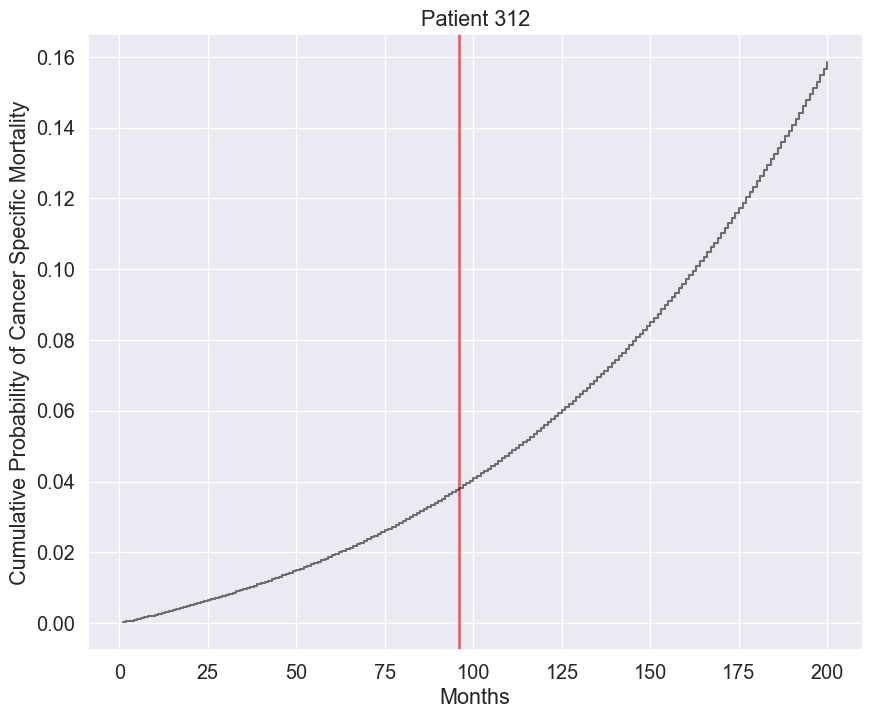

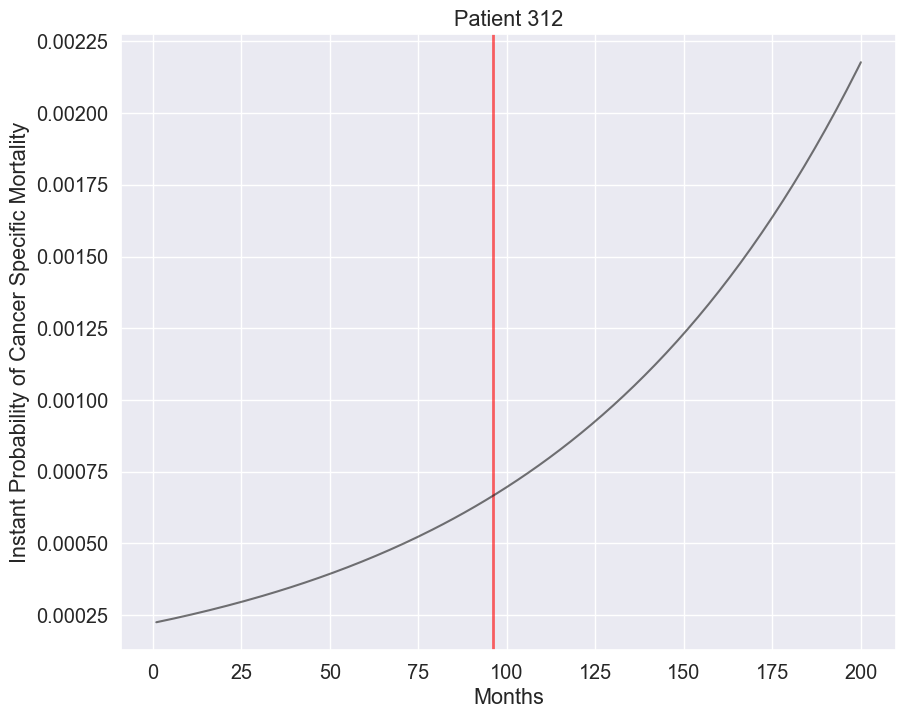

In [38]:
data_train_predicted = add_predict_probabilities(data_train, model=model, max_time=200, 
                                                 target_column='cancer_specific_mortality')

plot_single_patient(data_train_predicted, patient_id=312, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=False)

In [22]:
# patients with worst cancer specific cum. hazards
temp2 = data_train_predicted.groupby(['cancer_specific_mortality','patient_id'])['cumulative_hazard'].max()
temp2 = temp2.reset_index(name='cumulative_hazard') \
    .sort_values(['cancer_specific_mortality', 'cumulative_hazard'], ascending=False)
print(temp2.loc[temp2['cancer_specific_mortality'] == '1'])

print(temp2.loc[temp2['cancer_specific_mortality'] == '0'])

     cancer_specific_mortality  patient_id  cumulative_hazard
1218                         1          30           0.999963
1212                         1          17           0.998189
1221                         1          35           0.993406
1219                         1          31           0.973409
1211                         1          16           0.972120
1213                         1          19           0.963082
1220                         1          34           0.942117
1217                         1          28           0.937937
1239                         1         615           0.937093
1228                         1         182           0.876296
1216                         1          25           0.848375
1224                         1         173           0.762172
1230                         1         223           0.760788
1243                         1         672           0.717435
1229                         1         193           0.670102
1215    

In [25]:
data_train_predicted.loc[data_train_predicted['patient_id'] == 30].loc[:, 
                                                                       ['patient_id', 
                                                                        'survival_months', 
                                                                        'cancer_specific_mortality',
                                                                        'cancer_specific_mortality_discrete',
                                                                       'survival_time_discrete',
                                                                       'mortality_instant_prob',
                                                                       'cumulative_hazard']].head()

,patient_id,survival_months,cancer_specific_mortality,cancer_specific_mortality_discrete,survival_time_discrete,mortality_instant_prob,cumulative_hazard
101600,30,31,1,0.0,1,0.013585,0.013585
101601,30,31,1,0.0,2,0.013739,0.027137
101602,30,31,1,0.0,3,0.013894,0.040654
101603,30,31,1,0.0,4,0.014052,0.054135
101604,30,31,1,0.0,5,0.014211,0.067576


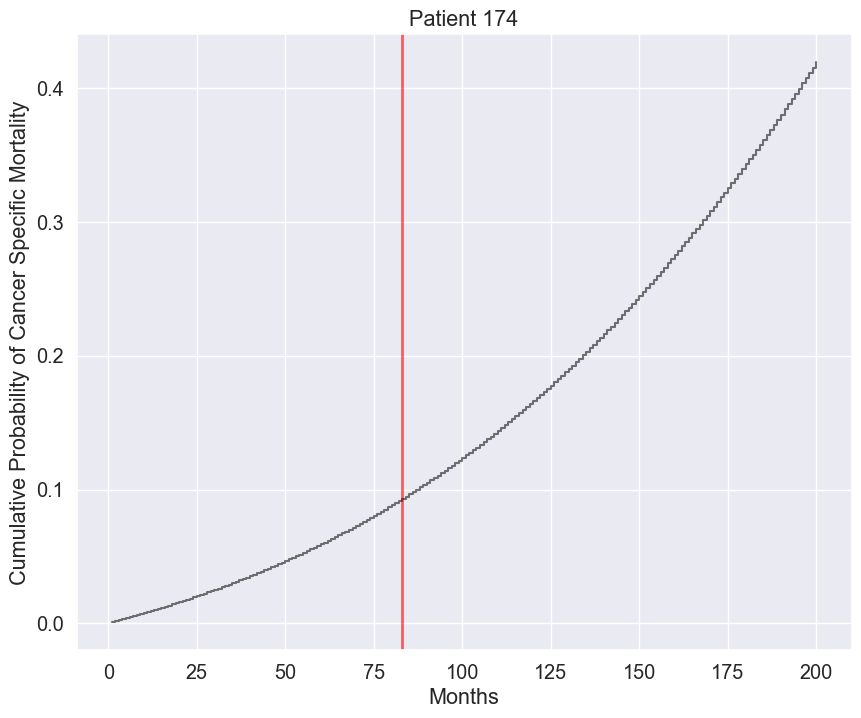

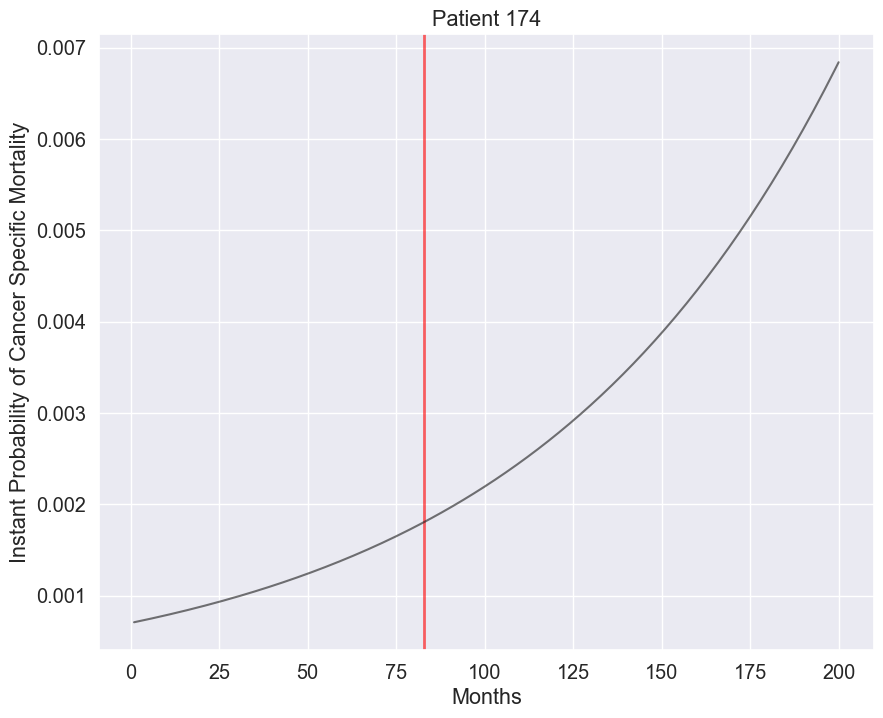

In [39]:
data_test_predicted = add_predict_probabilities(data_test, model=model, max_time=200, 
                                                 target_column='cancer_specific_mortality')

plot_single_patient(data_test_predicted, patient_id=174, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=False)

#### Experiments - training with different month periods

In [38]:
# list of months which will be tried out
trainable_months = list(range(24, 225, 12))

for target_column in ['cancer_specific_mortality', 'death_from_other_causes', 'mts', 'bcr']:
    for month in trainable_months:
        # Define the logistic regression model
        model = LogisticRegression(solver='liblinear', random_state=0)
        # Run the experiment
        run_experiment(df_train=data_train, df_test=data_test, model=model, 
                       max_time=month, target_column=target_column)

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/24/LogisticRegression"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/36/LogisticRegression"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/48/LogisticRegression"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/60/LogisticRegression"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fittin

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/mts_discrete/36/LogisticRegression"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/mts_discrete/48/LogisticRegression"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/mts_discrete/60/LogisticRegression"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/mts_discrete/72/LogisticRegression"...
	Finished saving reults.
Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/non_homog

### Based on homogenous data

#### Experiment - trained on single number of months

In [41]:
# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)

# Run the experiment
run_experiment(df_train=data_train_homogenous, df_test=data_test_homogenous, model=model, 
               max_time=200, target_column='cancer_specific_mortality',
              is_homogenous_dataset=True)

model, auc_stats = read_experiment('LogisticRegression', 'cancer_specific_mortality', 200,
                                  is_homogenous_dataset=True)

print(auc_stats)

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/homogenous_data/cancer_specific_mortality_discrete/200/LogisticRegression"...
	Finished saving reults.
    month  train_auc  test_auc  test_adjusted_auc
0       6        NaN       NaN                NaN
1      12        NaN       NaN                NaN
2      18   0.960396       NaN                NaN
3      24   0.935000       NaN                NaN
4      30   0.707071  0.964744           0.964744
5      36   0.770408  0.964744           0.964744
6      42   0.837594  0.964744           0.964744
7      48   0.859043  0.964744           0.964744
8      54   0.859043  0.964744           0.964744
9      60   0.856631  0.987097           0.987097
10     66   0.876087  0.987097           0.987097
11     72   0.876087  0.987097           0.987097
12     78   0.827778  0.987097           0.987097
13     84   0.827778  0.986246           0.986246
14     90   0.84

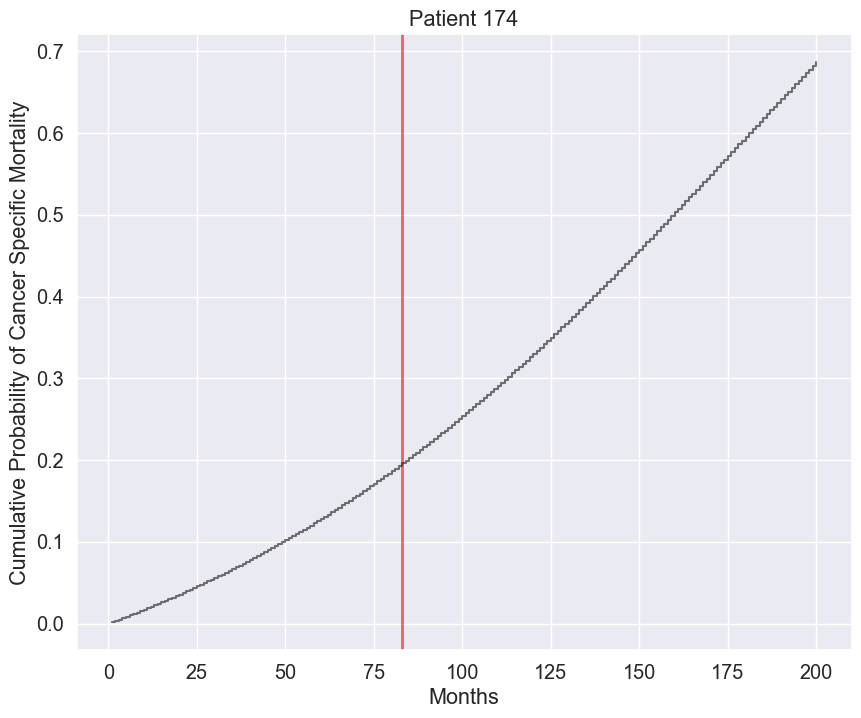

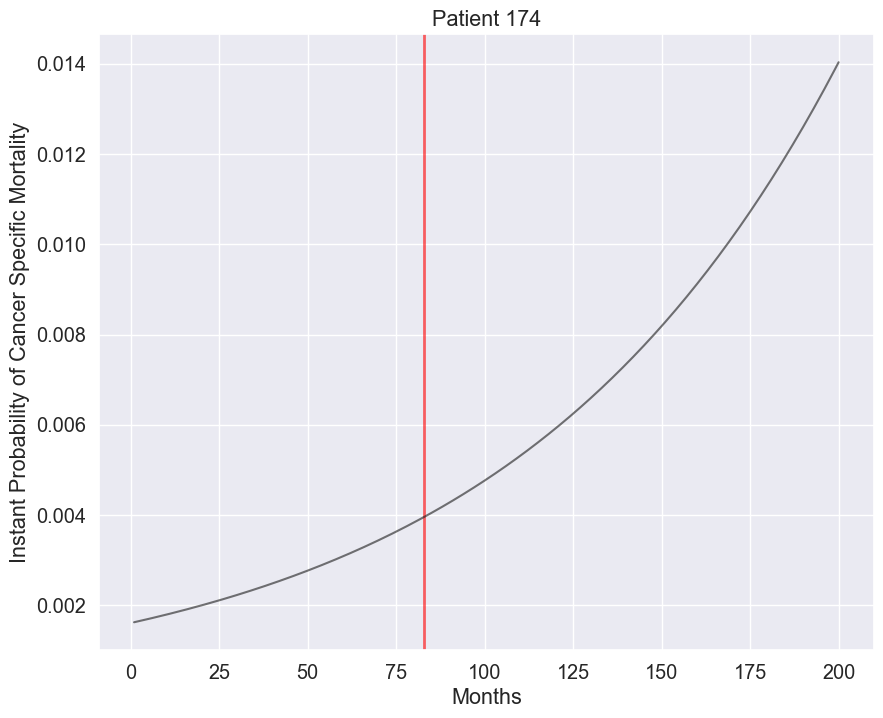

In [42]:
data_test_homogenous_predicted = add_predict_probabilities(data_test_homogenous, model=model, max_time=200, 
                                                 target_column='cancer_specific_mortality',
                                                          is_homogenous_dataset=True)

plot_single_patient(data_test_homogenous_predicted, patient_id=174, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=False)

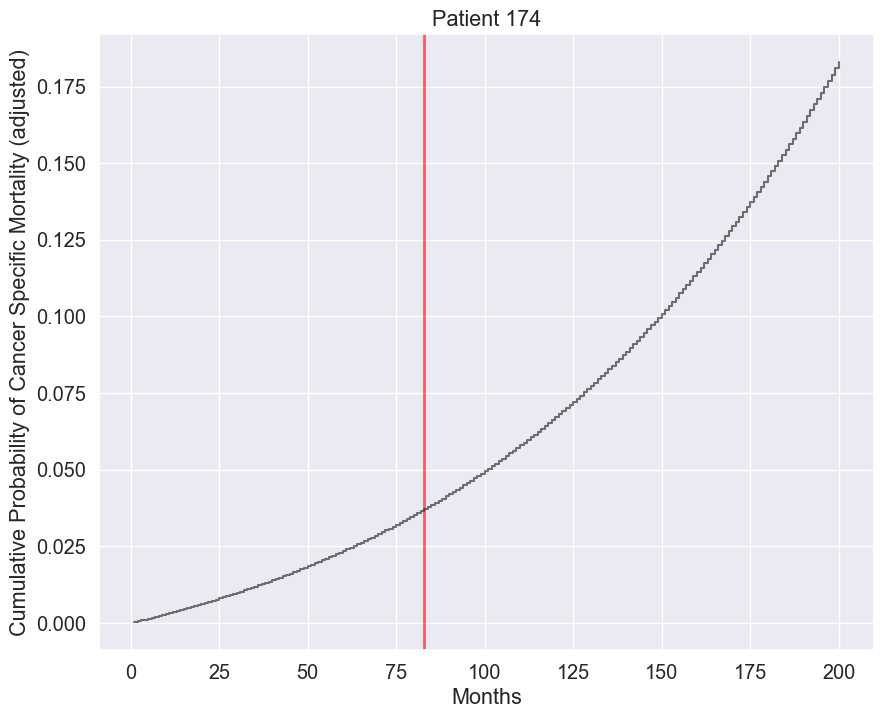

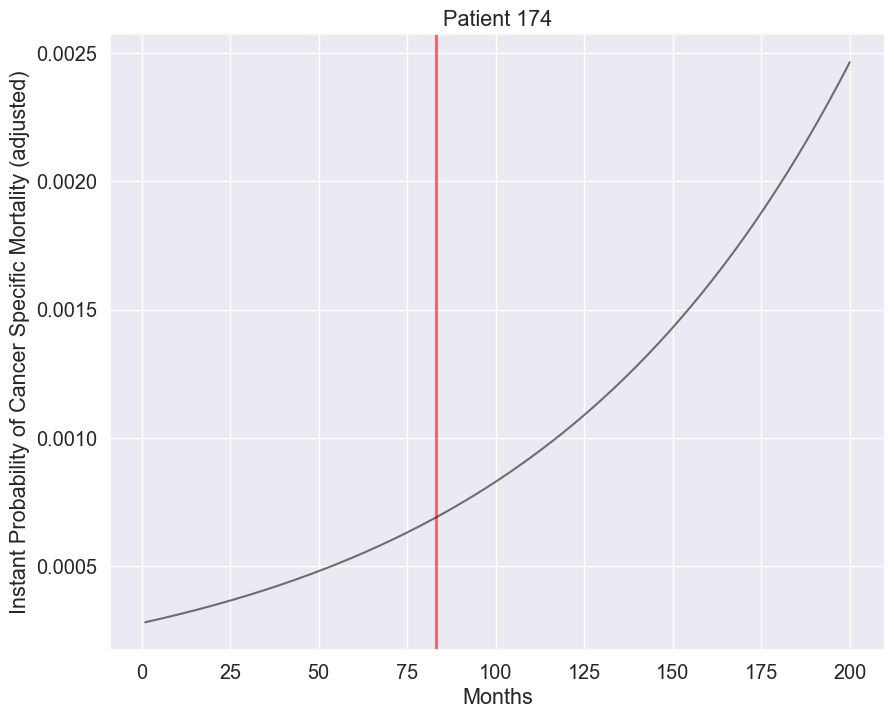

In [44]:
data_test_homogenous_predicted = add_predict_probabilities(data_test_homogenous, model=model, max_time=200, 
                                                 target_column='cancer_specific_mortality',
                                                          is_homogenous_dataset=True)

plot_single_patient(data_test_homogenous_predicted, patient_id=174, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality (adjusted)', fix_axis=False, is_homogenous_dataset=True)

## Random Forest

### Based on non-homogenous data

#### Hyperparameter optimization

In [19]:
 # List of columns names which will be dropped from feature set before fitting the model
x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                     'death_from_other_causes', 'cancer_specific_mortality',
                     'death_from_other_causes_discrete', 'mts_discrete',
                     'bcr_discrete', 'cancer_specific_mortality_discrete']

# Explode the dataset
df_train_copy_exploded = explode_data(data_train.copy(), max_time=200)

# Drop columns/targets from feature set
X_train = df_train_copy_exploded.drop(x_columns_to_drop, axis=1)

y_train = df_train_copy_exploded['cancer_specific_mortality']

In [20]:
from sklearn.model_selection import RandomizedSearchCV as RSCV

param_grid = {'n_estimators':np.arange(150,700,50),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [3, 5, 7, 9],
              'max_samples': [0.3, 0.5, 0.8]}

model = RSCV(RandomForestClassifier(), param_grid, n_iter=15, 
             random_state=0, verbose=2, n_jobs=n_jobs).fit(X_train, y_train)
model_best = model.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [22]:
# Best parameters
model.best_params_

{'n_estimators': 400, 'max_samples': 0.3, 'max_features': 0.1, 'max_depth': 3}

#### Experiment - trained on single number of months

In [20]:
# Random Forest
# Check for hyperparameter optimization:
# https://towardsdatascience.com/mastering-random-forests-a-comprehensive-guide-51307c129cb1#:~:text=Generally%2C%20we%20go%20with%20a,vary%20between%20each%20decision%20tree.
# ------------------------------
# Interesting fact, as we add more trees and change the max_depth and entropy, the most important feature
# changes significantly. With default parameters, only survival_time_discrete is important.
# With optimized parameters survival_time_discrete is not that important.
# ------------------------------
# Define the model
model = RandomForestClassifier(n_estimators=400, random_state=0, criterion='entropy', max_depth=3,
                              max_samples=0.3, max_features=0.1)

# Run the experiment
run_experiment(df_train=data_train, df_test=data_test, model=model, 
               max_time=216, target_column='cancer_specific_mortality')

model, auc_stats = read_experiment('RandomForestClassifier', 'cancer_specific_mortality', 216)

print(auc_stats)

Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/216/RandomForestClassifier"...
	Finished saving reults.
    month  train_auc  test_auc
0       6        NaN       NaN
1      12        NaN       NaN
2      18   0.988010       NaN
3      24   0.991994       NaN
4      30   0.985286  0.945513
5      36   0.987493  0.945513
6      42   0.979415  0.945513
7      48   0.981064  0.945513
8      54   0.980940  0.945513
9      60   0.981826  0.981720
10     66   0.967435  0.981720
11     72   0.940462  0.981720
12     78   0.929388  0.981720
13     84   0.923453  0.978964
14     90   0.926379  0.978964
15     96   0.922801  0.946753
16    102   0.922450  0.946753
17    108   0.912770  0.945168
18    114   0.905800  0.945168
19    120   0.904801  0.945168
20    126   0.907346  0.950980
21    132   0.909265  0.950980
22    138   0.905900  0.845082
23    

In [21]:
# on training set
data_train_predicted = add_predict_probabilities(data_train, model=model, max_time=216, 
                                                 target_column='cancer_specific_mortality')

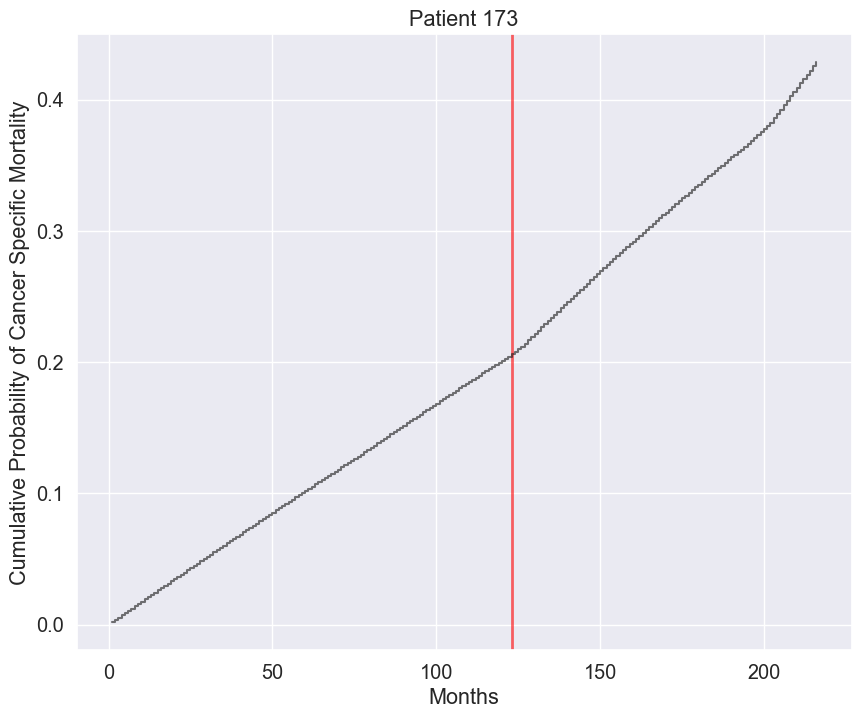

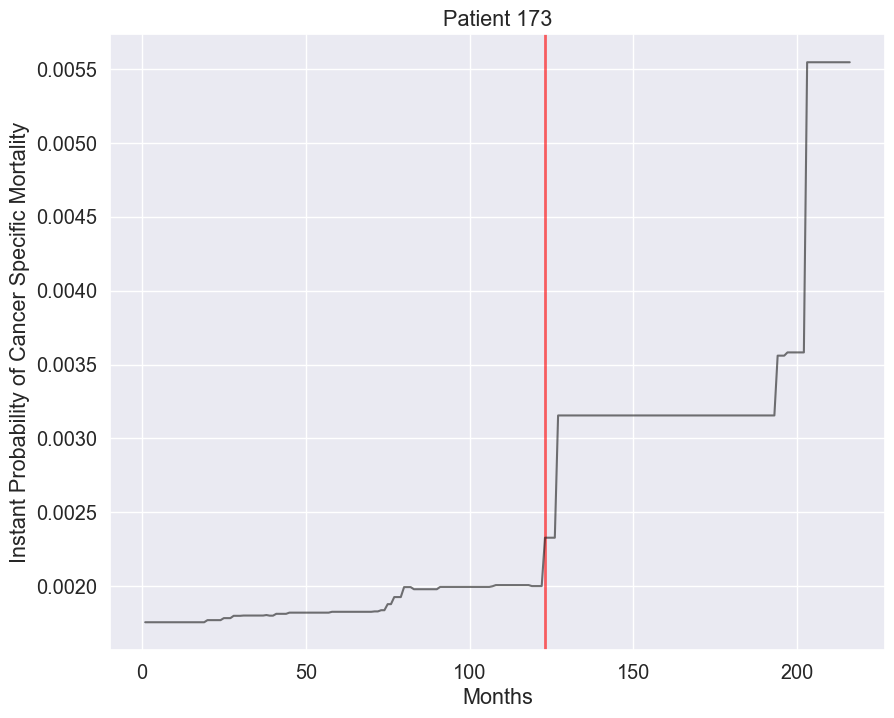

In [22]:
plot_single_patient(data_train_predicted, patient_id=173, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=False)

In [23]:
# on testing set
data_test_predicted = add_predict_probabilities(data_test, model=model, max_time=216, 
                                                 target_column='cancer_specific_mortality')

In [24]:
# patients with worst cancer specific cum. hazards
temp2 = data_test_predicted.groupby(['cancer_specific_mortality','patient_id'])['cumulative_hazard'].max()
temp2 = temp2.reset_index(name='cumulative_hazard') \
    .sort_values(['cancer_specific_mortality', 'cumulative_hazard'], ascending=False)
print(temp2.loc[temp2['cancer_specific_mortality'] == '1'])

print(temp2.loc[temp2['cancer_specific_mortality'] == '0'])

    cancer_specific_mortality  patient_id  cumulative_hazard
306                         1          41           0.614561
305                         1          23           0.589827
310                         1         195           0.456953
308                         1         174           0.429593
307                         1         142           0.351165
309                         1         194           0.225698
311                         1         642           0.123025
312                         1        1004           0.057188
    cancer_specific_mortality  patient_id  cumulative_hazard
5                           0          43           0.680342
4                           0          39           0.627226
3                           0          38           0.623556
0                           0          18           0.567487
6                           0          44           0.539923
..                        ...         ...                ...
261                     

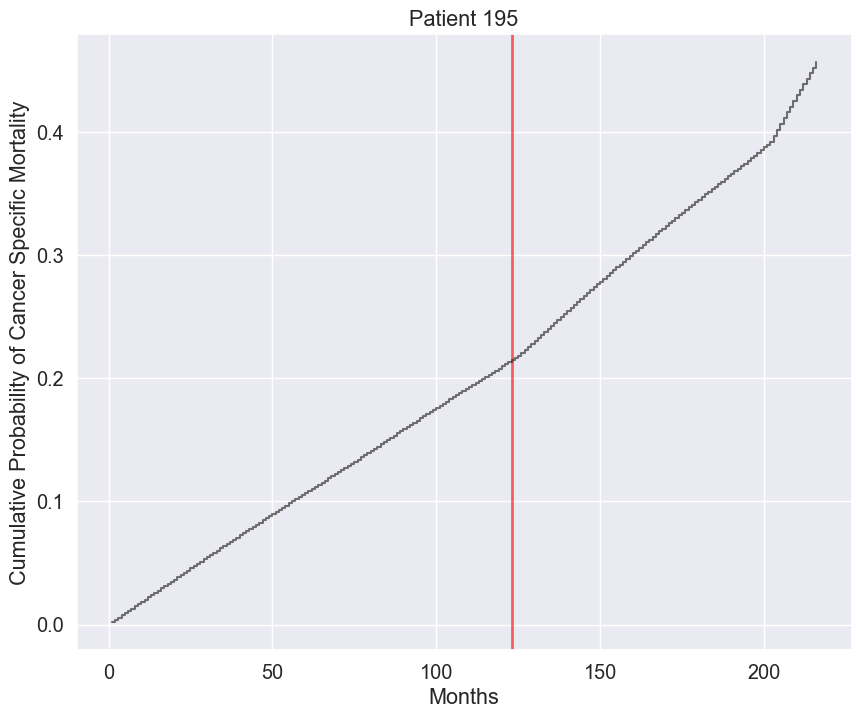

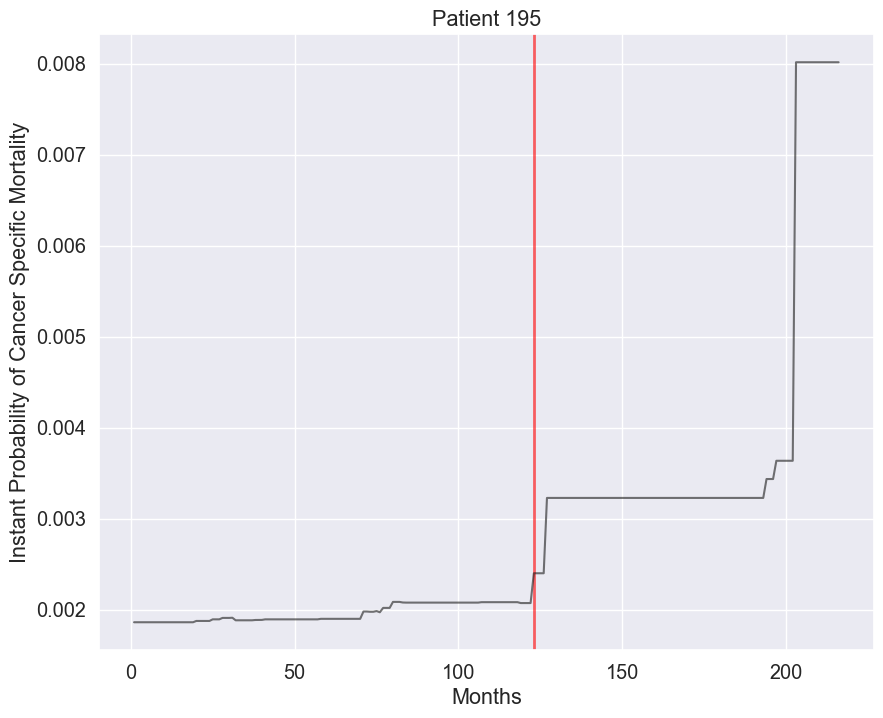

In [25]:
plot_single_patient(data_test_predicted, patient_id=195, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=False)

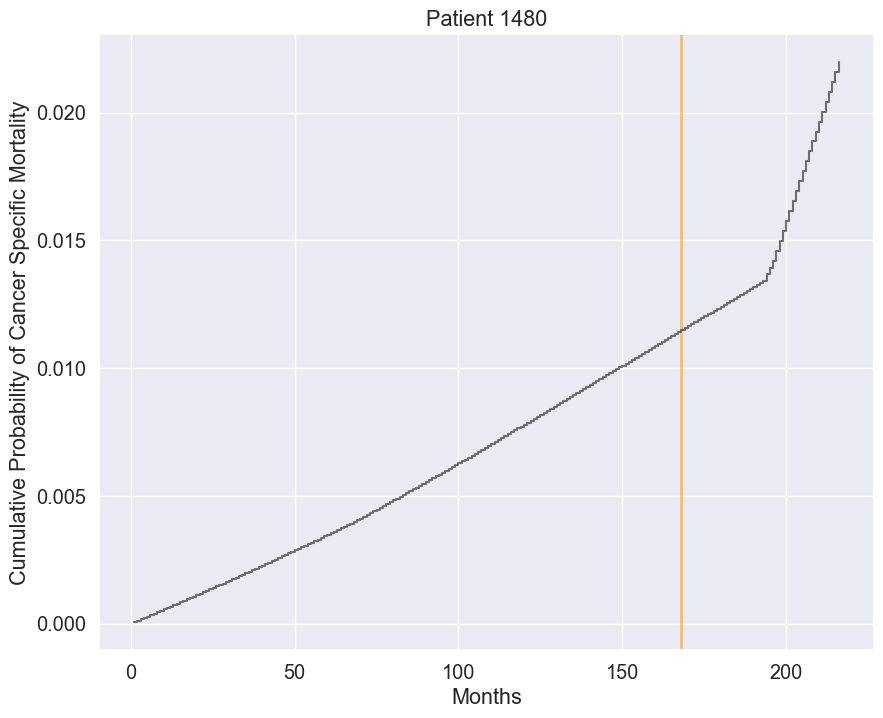

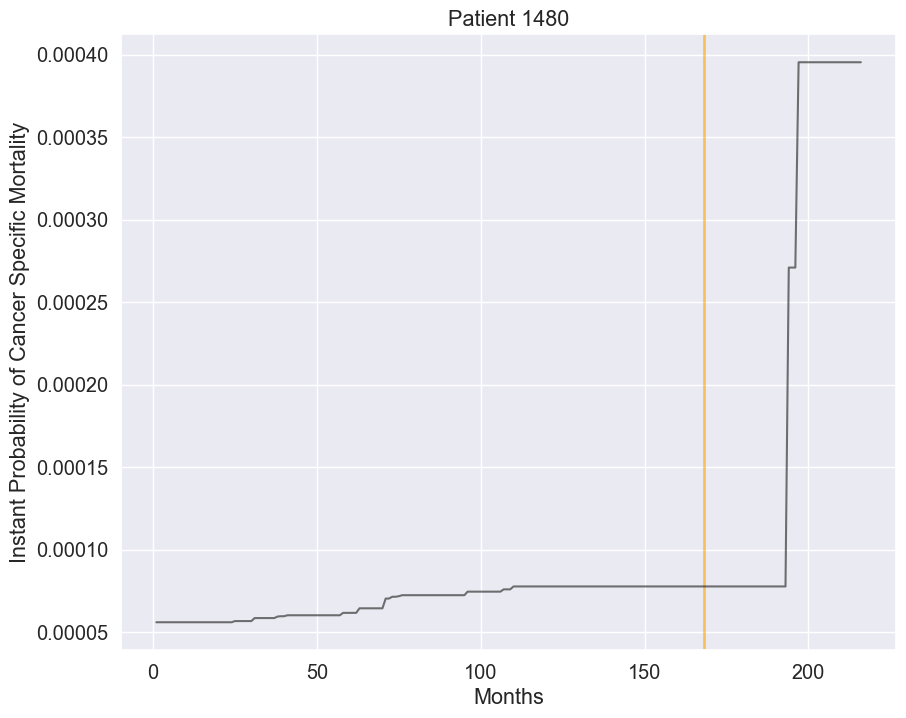

In [26]:
plot_single_patient(data_test_predicted, patient_id=1480, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=False)

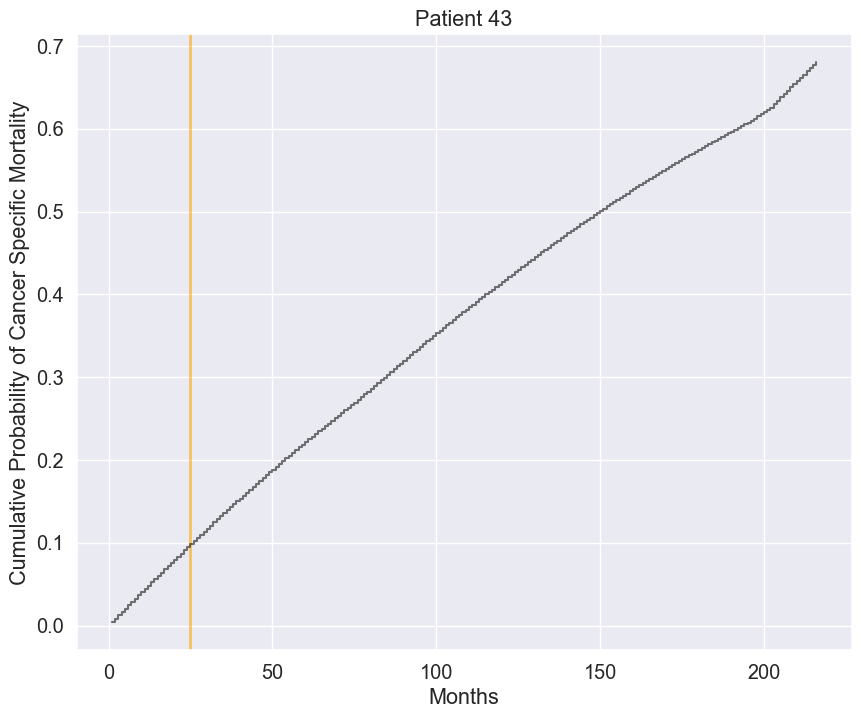

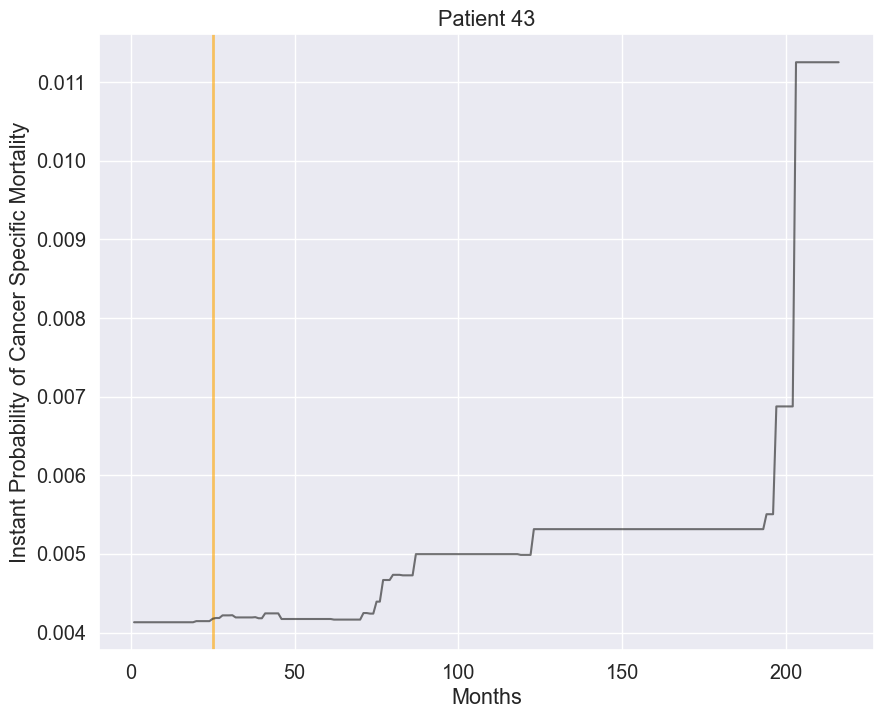

In [27]:
plot_single_patient(data_test_predicted, patient_id=43, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=False)

#### Experiments - training with different month periods

In [44]:
# list of months which will be tried out
trainable_months = list(range(24, 225, 12))

for target_column in ['cancer_specific_mortality', 'death_from_other_causes', 'mts', 'bcr']:
    for month in trainable_months:
        # Define the Random Forest model
        model = RandomForestClassifier(n_estimators=400, random_state=0, criterion='entropy', max_depth=3,
                              max_samples=0.3, max_features=0.1)
        # Run the experiment
        run_experiment(df_train=data_train, df_test=data_test, model=model, 
                       max_time=month, target_column=target_column)

Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/24/RandomForestClassifier"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/36/RandomForestClassifier"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/48/RandomForestClassifier"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/60/RandomForestClassifier"...
	Finished saving reults.
Expe

Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/death_from_other_causes_discrete/216/RandomForestClassifier"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/mts_discrete/24/RandomForestClassifier"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/mts_discrete/36/RandomForestClassifier"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomForestClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/mts_discrete/48/RandomForestClassifier"...
	Finished saving reults.
Experiment with RandomForestClassifier:
	Starting fitting a RandomFores

## XGBoost

### Based on non-homogenous data

#### Hyperparameter optimization

In [42]:
 # List of columns names which will be dropped from feature set before fitting the model
x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                     'death_from_other_causes', 'cancer_specific_mortality',
                     'death_from_other_causes_discrete', 'mts_discrete',
                     'bcr_discrete', 'cancer_specific_mortality_discrete']

# Explode the dataset
df_train_copy_exploded = explode_data(data_train.copy(), max_time=200)

# Drop columns/targets from feature set
X_train = df_train_copy_exploded.drop(x_columns_to_drop, axis=1)

y_train = df_train_copy_exploded['cancer_specific_mortality']

y_train = y_train.astype({'cancer_specific_mortality': 'int32'})

In [43]:
# Explode the dataset
df_test_copy_exploded = explode_data(data_test.copy(), max_time=200)

# Drop columns/targets from feature set
X_test = df_test_copy_exploded.drop(x_columns_to_drop, axis=1)

y_test = df_test_copy_exploded['cancer_specific_mortality']

y_test = y_test.astype({'cancer_specific_mortality': 'int32'})

In [72]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

xgb_model = XGBClassifier()

#params = {
#    "colsample_bytree": uniform(0.7, 0.3),
#    "gamma": uniform(0, 0.5),
#    "learning_rate": uniform(0.03, 0.3), # default 0.1 
#    "max_depth": randint(2, 6), # default 3
#    "n_estimators": randint(100, 150), # default 100
#    "subsample": uniform(0.6, 0.4)
#}

params = {
    "colsample_bytree": [ 0.5, 0.6, 0.7, 0.8, 1 ],
    "gamma": [ 0.0, 0.01, 0.05, 0.1, 0.2 , 0.3, 0.4 ],
    "learning_rate": [0.01, 0.05, 0.10, 0.15, 0.20], # default 0.1 
    "max_depth": [ 2, 3, 4, 5, 6, 7, 8 ], # default 3
    "min_child_weight": [ 1, 3, 5, 7 ],
    "n_estimators": [50, 100, 150, 200, 250, 300, 350, 400], # default 100
    "subsample": [0.2, 0.4, 0.6, 0.8, 1],
    #"scale_pos_weight": [42/1210, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.5],
    "reg_alpha": [0, 0.001, 0.01, 0.1],
    "reg_lambda": [0, 0.001, 0.1, 1, 5, 10]
}

search = RandomizedSearchCV(xgb_model, param_distributions=params,
                            scoring='roc_auc',
                            random_state=42, n_iter=100, 
                            cv=3, verbose=3, n_jobs=n_jobs, return_train_score=True)

# Explode the dataset
df_train_copy_exploded = explode_data(data_train, max_time=200)

# List of columns names which will be dropped from feature set before fitting the model
x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                     'death_from_other_causes', 'cancer_specific_mortality',
                     'death_from_other_causes_discrete', 'mts_discrete',
                     'bcr_discrete', 'cancer_specific_mortality_discrete']

# Drop columns/targets from feature set
if x_columns_to_drop is not None:
    X_train = df_train_copy_exploded.drop(x_columns_to_drop, axis=1)
else:    
    X_train = df_train_copy_exploded.drop('cancer_specific_mortality_discrete', axis=1)

y_train = df_train_copy_exploded['cancer_specific_mortality_discrete']




search.fit(X_train, y_train)



Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                        'gamma': [0.0, 0.01, 0.05, 0.1, 0.2,
                                                  0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400],
                                        'reg_alpha': [0, 0.001, 0.01, 0.1],
                                        'reg_lambda': [0, 0.001, 0.1, 1, 5, 10],
                                        'subsample': [0.2, 0.4, 0.6, 0.8, 1]},
                   random_state=42, return_train_score=True, scoring='roc_auc',
                   verbose=3)

In [73]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report_best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.893 (std: 0.007)
Parameters: {'subsample': 0.2, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.7}



In [109]:
# XGBoost
# Define the model
# 198 month: 0.89 | 0.81
#model = XGBClassifier(objective="binary:logistic", random_state=0, 
#                      colsample_bytree=0.4, gamma=0, learning_rate=0.2,
#                      max_depth=12, n_estimators=250, subsample = 0.2,
#                     min_child_weight=3, scale_pos_weight=0.8)
#scale_pos_weight=42/1210

# 198 month: 0.88 | 0.835
model = XGBClassifier(objective="binary:logistic", random_state=0, booster='gbtree',
                      colsample_bytree=0.2, gamma=0.1, learning_rate=0.1,
                      max_depth=4, n_estimators=500, subsample = 0.2,
                     min_child_weight=3, scale_pos_weight=0.7, 
                      reg_lambda=1, reg_alpha=0.001)

# 198 month: 0.88 | 0.836
#model = XGBClassifier(objective="binary:logistic", random_state=0, booster='gbtree',
#                      colsample_bytree=0.7, gamma=0.1, learning_rate=0.2,
#                      max_depth=4, n_estimators=300, subsample = 0.2,
#                     min_child_weight=6, scale_pos_weight=1, 
#                      reg_lambda=1, reg_alpha=0.001)

# Run the experiment
run_experiment(df_train=data_train, df_test=data_test, model=model, 
               max_time=200, target_column='cancer_specific_mortality')

model, auc_stats = read_experiment('XGBClassifier', 'cancer_specific_mortality', 200)

print(auc_stats)

Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/200/XGBClassifier"...
	Finished saving reults.
    month  train_auc  test_auc
0       6        NaN       NaN
1      12        NaN       NaN
2      18   0.989209       NaN
3      24   0.982252       NaN
4      30   0.976257  0.894231
5      36   0.980321  0.894231
6      42   0.981100  0.894231
7      48   0.981406  0.894231
8      54   0.981406  0.894231
9      60   0.976662  0.962366
10     66   0.961595  0.962366
11     72   0.930055  0.962366
12     78   0.919305  0.963441
13     84   0.906842  0.961165
14     90   0.909448  0.961165
15     96   0.906885  0.934091
16    102   0.908279  0.934740
17    108   0.902839  0.941640
18    114   0.890454  0.942182
19    120   0.889353  0.943811
20    126   0.892669  0.949346
21    132   0.894750  0.948413
22    138   0.888537  0.836270
23    144   0.888646  0.836270
24    150   0.888399  

#### Experiment - trained on single number of months

In [34]:
model = XGBClassifier(objective="binary:logistic", random_state=0, booster='gbtree',
                      colsample_bytree=0.2, gamma=0.1, learning_rate=0.1,
                      max_depth=4, n_estimators=500, subsample = 0.2,
                     min_child_weight=3, scale_pos_weight=0.7, 
                      reg_lambda=1, reg_alpha=0.001)

# Run the experiment
run_experiment(df_train=data_train, df_test=data_test, model=model, 
               max_time=200, target_column='cancer_specific_mortality')

model, auc_stats = read_experiment('XGBClassifier', 'cancer_specific_mortality', 200)

print(auc_stats)

Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/200/XGBClassifier"...
	Finished saving reults.
    month  train_auc  test_auc
0       6        NaN       NaN
1      12        NaN       NaN
2      18   0.989608       NaN
3      24   0.989592       NaN
4      30   0.977394  0.887821
5      36   0.981297  0.887821
6      42   0.973262  0.887821
7      48   0.975477  0.887821
8      54   0.975477  0.887821
9      60   0.965267  0.956989
10     66   0.948827  0.956989
11     72   0.919671  0.956989
12     78   0.912265  0.956989
13     84   0.908991  0.960356
14     90   0.911353  0.960356
15     96   0.907830  0.902597
16    102   0.908047  0.902597
17    108   0.898215  0.915852
18    114   0.888281  0.915852
19    120   0.888379  0.915852
20    126   0.891847  0.922969
21    132   0.894906  0.922969
22    138   0.882934  0.835656
23    144   0.882934  0.835656
24    150   0.884404  

In [35]:
# on training set
data_train_predicted = add_predict_probabilities(data_train, model=model, max_time=200, 
                                                 target_column='cancer_specific_mortality')

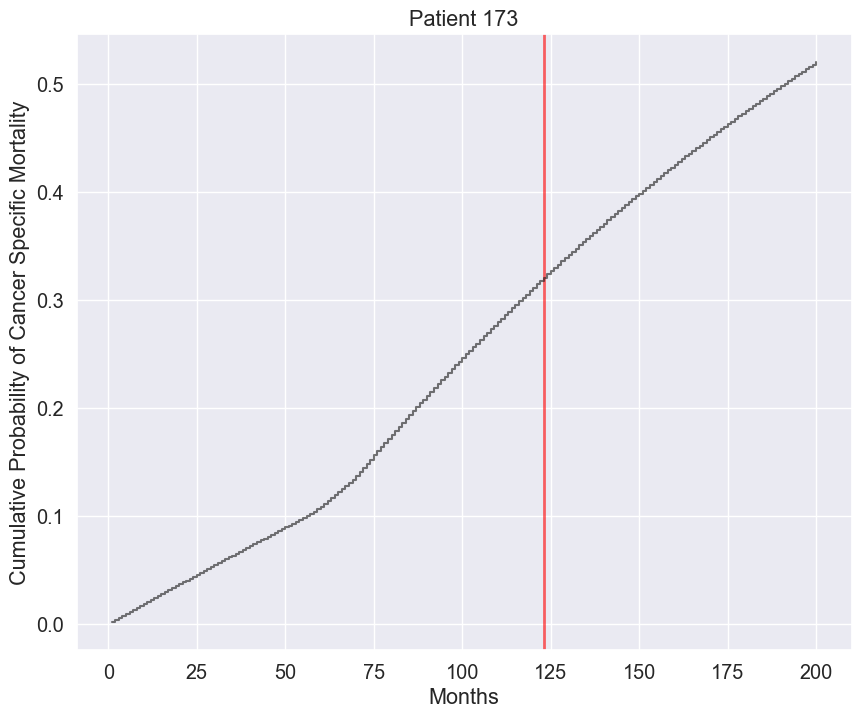

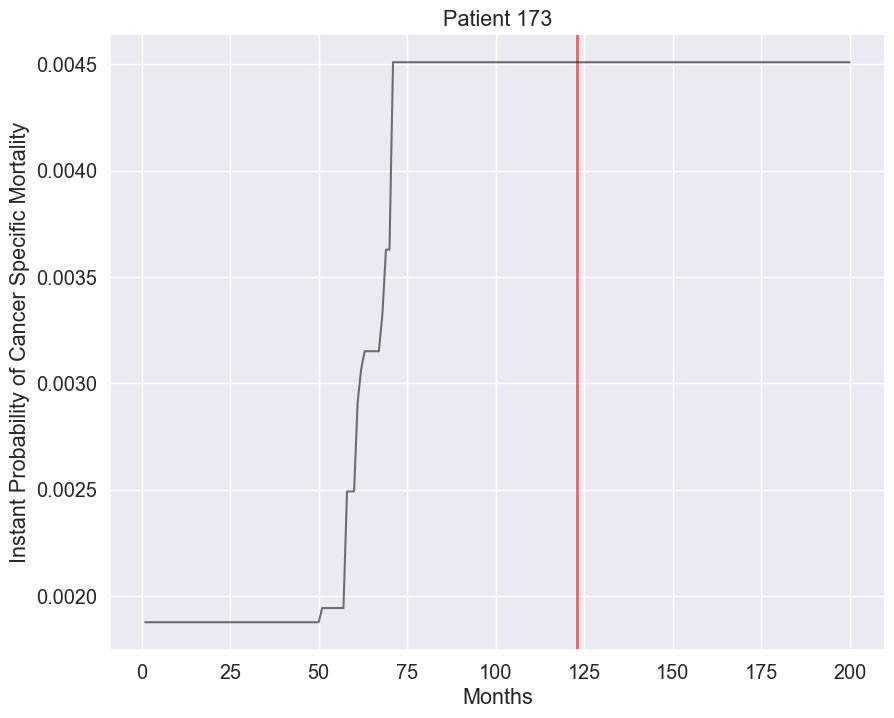

In [36]:
plot_single_patient(data_train_predicted, patient_id=173, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=False)

In [37]:
# on testing set
data_test_predicted = add_predict_probabilities(data_test, model=model, max_time=200, 
                                                 target_column='cancer_specific_mortality')

In [38]:
# patients with worst cancer specific cum. hazards
temp2 = data_test_predicted.groupby(['cancer_specific_mortality','patient_id'])['cumulative_hazard'].max()
temp2 = temp2.reset_index(name='cumulative_hazard') \
    .sort_values(['cancer_specific_mortality', 'cumulative_hazard'], ascending=False)
print(temp2.loc[temp2['cancer_specific_mortality'] == '1'])

print(temp2.loc[temp2['cancer_specific_mortality'] == '0'])

    cancer_specific_mortality  patient_id  cumulative_hazard
305                         1          23           0.415416
306                         1          41           0.398126
309                         1         194           0.334021
308                         1         174           0.314096
310                         1         195           0.276552
307                         1         142           0.125828
311                         1         642           0.041650
312                         1        1004           0.015862
    cancer_specific_mortality  patient_id  cumulative_hazard
4                           0          39           0.543712
2                           0          36           0.424179
24                          0         183           0.420499
29                          0         200           0.400952
35                          0         213           0.384857
..                        ...         ...                ...
223                     

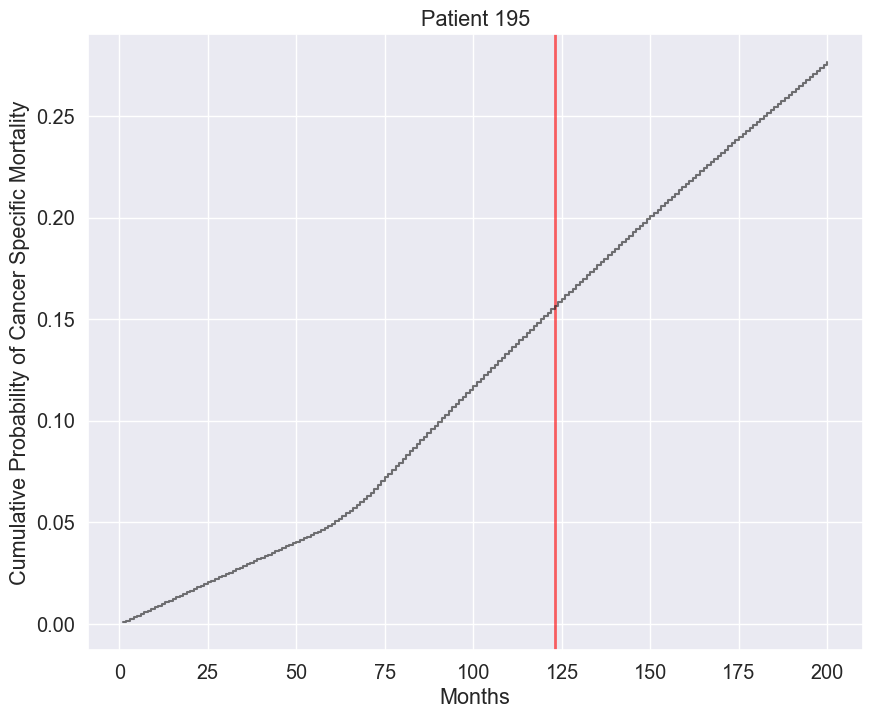

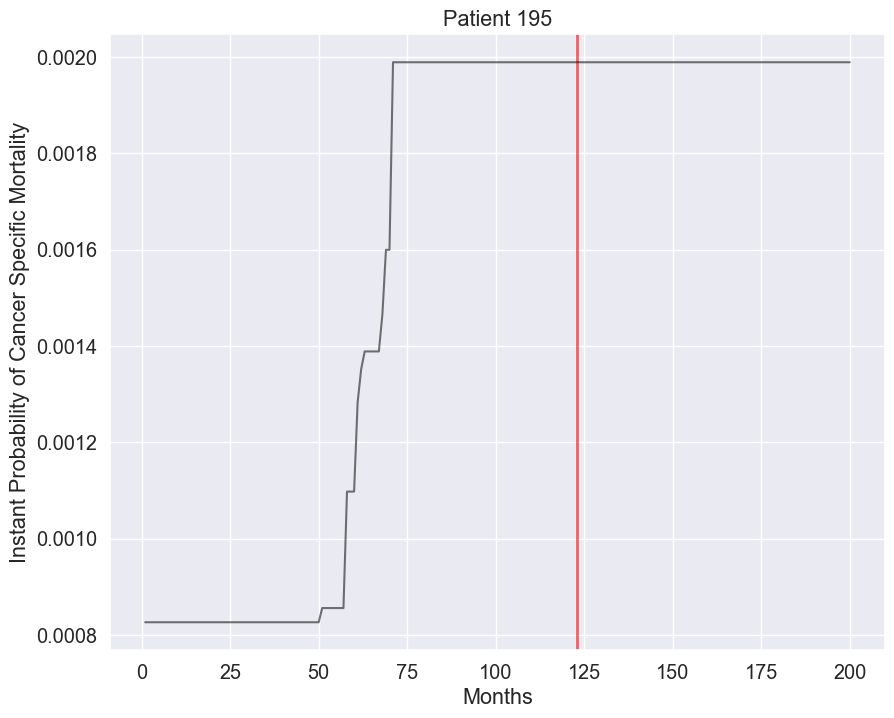

In [39]:
plot_single_patient(data_test_predicted, patient_id=195, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=False)

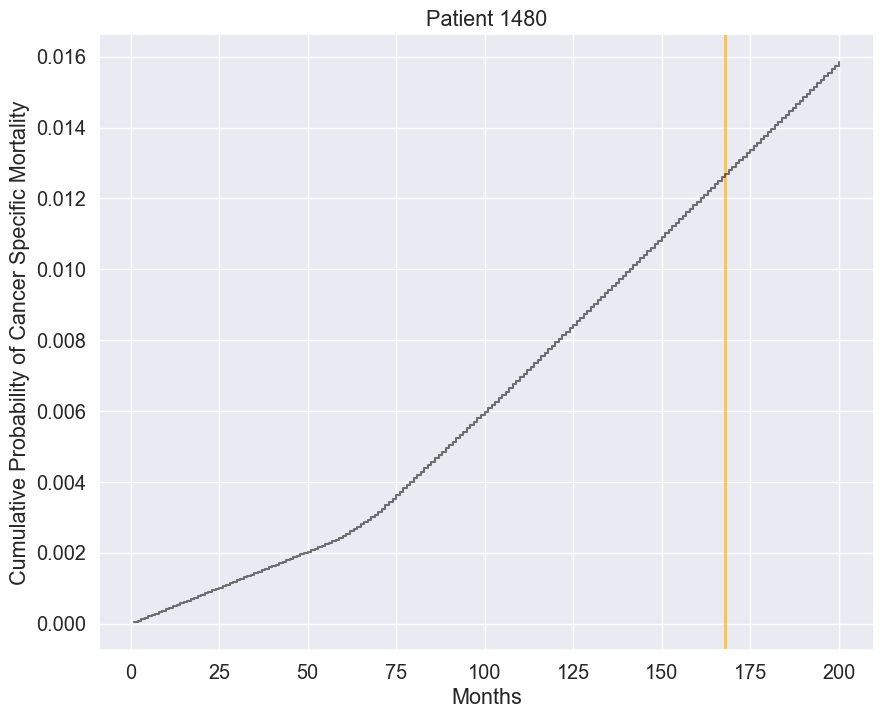

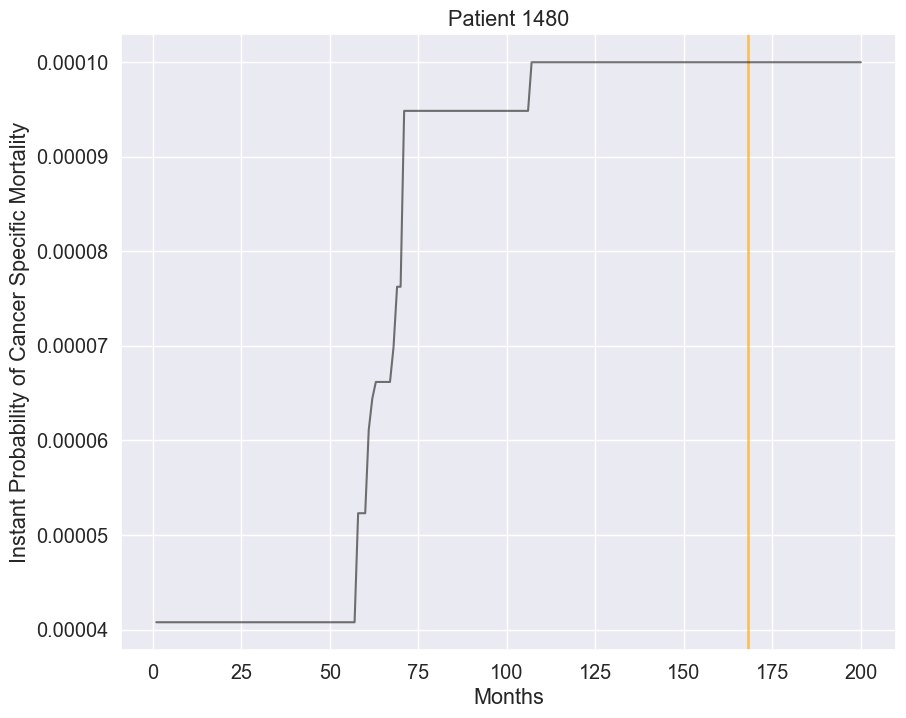

In [40]:
plot_single_patient(data_test_predicted, patient_id=1480, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=False)

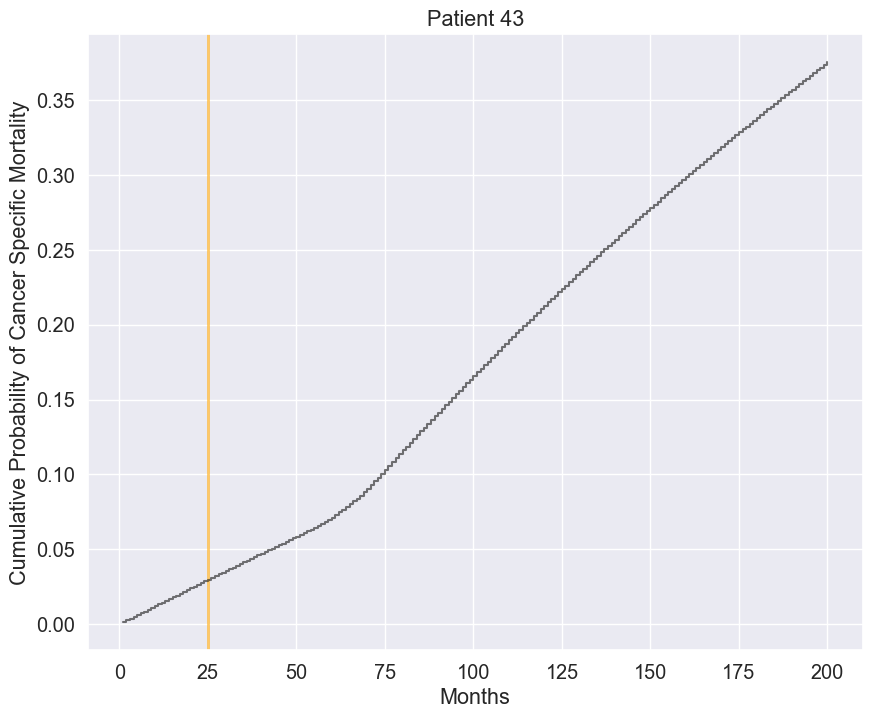

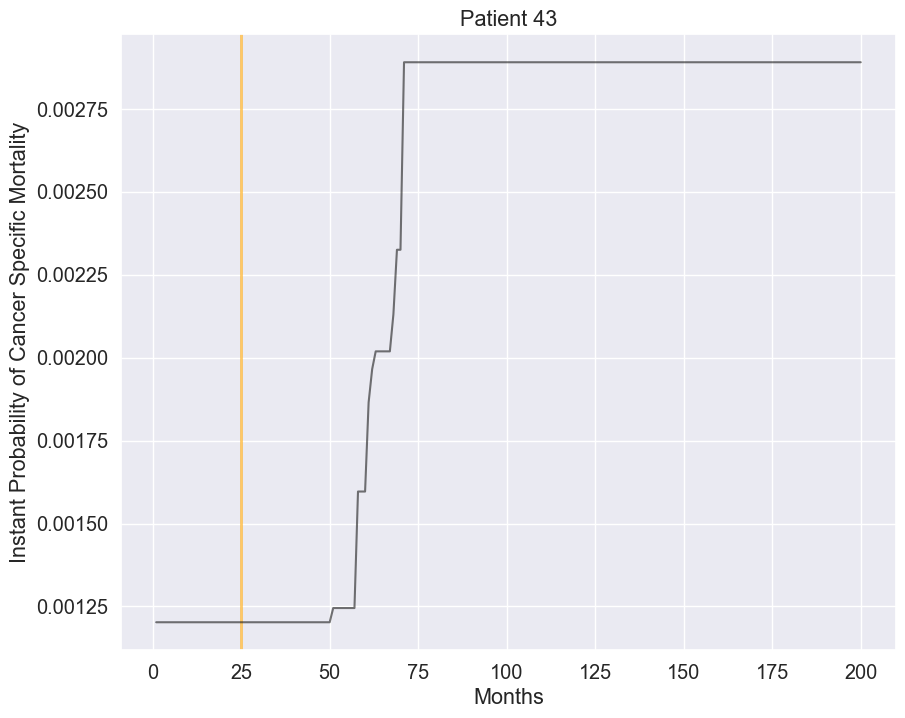

In [41]:
plot_single_patient(data_test_predicted, patient_id=43, target_column='cancer_specific_mortality', 
                    target_title='Cancer Specific Mortality', fix_axis=False)

#### Experiments - training with different month periods

In [45]:
# list of months which will be tried out
trainable_months = list(range(24, 225, 12))

for target_column in ['cancer_specific_mortality', 'death_from_other_causes', 'mts', 'bcr']:
    for month in trainable_months:
        # Define the Random Forest model
        model = XGBClassifier(objective="binary:logistic", random_state=0, booster='gbtree',
                      colsample_bytree=0.2, gamma=0.1, learning_rate=0.1,
                      max_depth=4, n_estimators=500, subsample = 0.2,
                     min_child_weight=3, scale_pos_weight=0.7, 
                      reg_lambda=1, reg_alpha=0.001)
        # Run the experiment
        run_experiment(df_train=data_train, df_test=data_test, model=model, 
                       max_time=month, target_column=target_column)

Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/24/XGBClassifier"...
	Finished saving reults.
Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/36/XGBClassifier"...
	Finished saving reults.
Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/48/XGBClassifier"...
	Finished saving reults.
Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/cancer_specific_mortality_discrete/60/XGBClassifier"...
	Finished saving reults.
Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to 

	Finished fitting.
	Saving results to "results/non_homogenous_data/mts_discrete/60/XGBClassifier"...
	Finished saving reults.
Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/mts_discrete/72/XGBClassifier"...
	Finished saving reults.
Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/mts_discrete/84/XGBClassifier"...
	Finished saving reults.
Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/mts_discrete/96/XGBClassifier"...
	Finished saving reults.
Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...
	Finished fitting.
	Saving results to "results/non_homogenous_data/mts_discrete/108/XGBClassifier"...
	Finished saving reults.
Experiment with XGBClassifier:
	Starting fitting a XGBClassifier model...

In [46]:
# read all auc statistics ant save as csv


root = 'results\\non_homogenous_data'
pattern = "*_statistics.pkl"
all_auc_statistics = pd.DataFrame()
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            filename = os.path.join(path, name)
            print(filename)
            myfile = open(filename,"rb")
            temp = pickle.load(myfile)
            myfile.close()
            
            subdirectories = filename.split('\\')
            dataset_type = subdirectories[1]
            target_column = subdirectories[2]
            months_trained = subdirectories[3]
            model_name = subdirectories[4]
            
            temp['dataset_type'] = dataset_type
            temp['target_column'] = target_column
            temp['months_trained'] = months_trained
            temp['model_name'] = model_name
            
            all_auc_statistics = pd.concat([all_auc_statistics, temp])

all_auc_statistics.to_csv('all_auc_statistics.csv', index=False)

results\non_homogenous_data\bcr_discrete\108\LogisticRegression\auc_statistics.pkl
results\non_homogenous_data\bcr_discrete\108\RandomForestClassifier\auc_statistics.pkl
results\non_homogenous_data\bcr_discrete\108\XGBClassifier\auc_statistics.pkl
results\non_homogenous_data\bcr_discrete\120\LogisticRegression\auc_statistics.pkl
results\non_homogenous_data\bcr_discrete\120\RandomForestClassifier\auc_statistics.pkl
results\non_homogenous_data\bcr_discrete\120\XGBClassifier\auc_statistics.pkl
results\non_homogenous_data\bcr_discrete\132\LogisticRegression\auc_statistics.pkl
results\non_homogenous_data\bcr_discrete\132\RandomForestClassifier\auc_statistics.pkl
results\non_homogenous_data\bcr_discrete\132\XGBClassifier\auc_statistics.pkl
results\non_homogenous_data\bcr_discrete\144\LogisticRegression\auc_statistics.pkl
results\non_homogenous_data\bcr_discrete\144\RandomForestClassifier\auc_statistics.pkl
results\non_homogenous_data\bcr_discrete\144\XGBClassifier\auc_statistics.pkl
results\

results\non_homogenous_data\death_from_other_causes_discrete\156\LogisticRegression\auc_statistics.pkl
results\non_homogenous_data\death_from_other_causes_discrete\156\RandomForestClassifier\auc_statistics.pkl
results\non_homogenous_data\death_from_other_causes_discrete\156\XGBClassifier\auc_statistics.pkl
results\non_homogenous_data\death_from_other_causes_discrete\168\LogisticRegression\auc_statistics.pkl
results\non_homogenous_data\death_from_other_causes_discrete\168\RandomForestClassifier\auc_statistics.pkl
results\non_homogenous_data\death_from_other_causes_discrete\168\XGBClassifier\auc_statistics.pkl
results\non_homogenous_data\death_from_other_causes_discrete\180\LogisticRegression\auc_statistics.pkl
results\non_homogenous_data\death_from_other_causes_discrete\180\RandomForestClassifier\auc_statistics.pkl
results\non_homogenous_data\death_from_other_causes_discrete\180\XGBClassifier\auc_statistics.pkl
results\non_homogenous_data\death_from_other_causes_discrete\192\LogisticReg

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/100/LogisticRegression"...


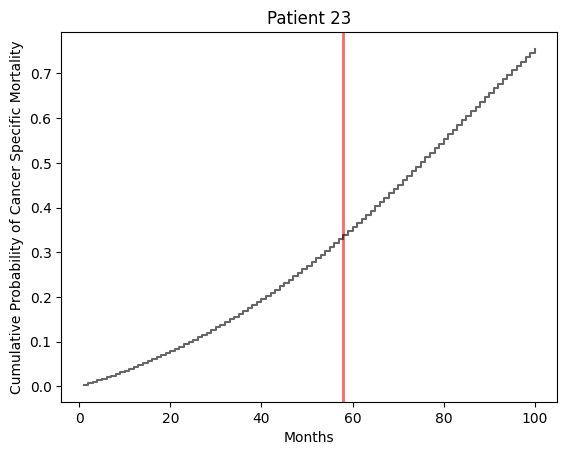

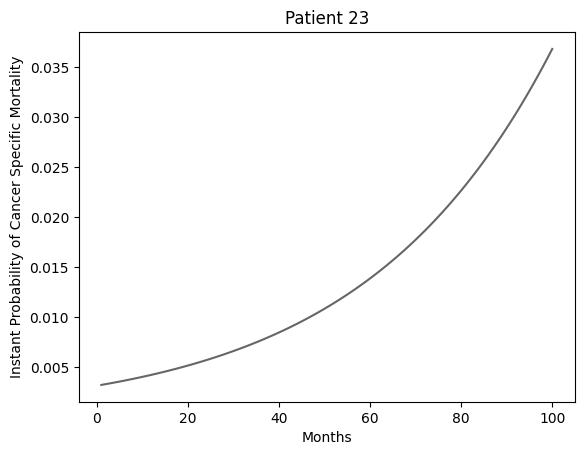

    month  train_auc  test_auc
0       6        NaN       NaN
1      12        NaN       NaN
2      18   0.991207       NaN
3      24   0.986923       NaN
4      30   0.974719  0.721154
5      36   0.978887  0.721154
6      42   0.979708  0.721154
7      48   0.979015  0.721154
8      54   0.979015  0.721154
9      60   0.972883  0.906452
10     66   0.957625  0.906452
11     72   0.934889  0.906452
12     78   0.928574  0.906452
13     84   0.928222  0.890777
14     90   0.931156  0.890777
15     96   0.930527  0.874026


In [13]:
# ONE EXPERIMENT
# At which time we'll clip out the data
max_time = 100
target_column = 'cancer_specific_mortality'
target_title = 'Cancer Specific Mortality'


# List of columns names which will be dropped from feature set before fitting the model
x_columns_to_drop = ['survival_months', 'patient_id', 'bcr', 'mts',
                     'death_from_other_causes', 'cancer_specific_mortality',
                     'death_from_other_causes_discrete', 'mts_discrete',
                     'bcr_discrete', 'cancer_specific_mortality_discrete']

# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)
model = train_model(model=model, df_train=data_train, target_column=target_column+'_discrete',
                   max_time=max_time, x_columns_to_drop=x_columns_to_drop)

# Test on training data
data_train_predicted = add_predict_probabilities(data_train, model=model, max_time=max_time, 
                                                 target_column=target_column)

# Test on testing data
data_test_predicted = add_predict_probabilities(data_test, model=model, max_time=max_time, 
                                                target_column=target_column)

plot_single_patient(data_test_predicted, patient_id=23, 
                    target_column=target_column, 
                    target_title=target_title, fix_axis=False)

# Discrimination Metrics
# AUC for each cumulative slice

# Months at which we'll check the AUC's
check_months = list(range(6, max_time, 6))

train_auc_stats = []
test_auc_stats = []
for w in check_months:
    # --- Training data ---
    # Selecting a subset of data based on the months
    select = (data_train_predicted['survival_time_discrete'] == w) & pd.notna(data_train_predicted[target_column+'_cumulative'])
    sub_dat = data_train_predicted[select]
    
    # If in the sliced data there's a event, calculate AUC metric,
    # otherwise assign NaN value
    if sub_dat[target_column+'_cumulative'].max() == 1:
        fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
        auc_stat = auc(fpr, tpr)
    else:
        auc_stat = float('NaN')
    train_auc_stats.append(auc_stat)
    
    # --- Testing data ---
    # Selecting a subset of data based on the months
    select = (data_test_predicted['survival_time_discrete'] == w) & pd.notna(data_test_predicted[target_column+'_cumulative'])
    sub_dat = data_test_predicted[select]
    
    # If in the sliced data there's a event, calculate AUC metric,
    # otherwise assign NaN value
    if sub_dat[target_column+'_cumulative'].max() == 1:
        fpr, tpr, thresholds = roc_curve(sub_dat[target_column+'_cumulative'], sub_dat['cumulative_hazard'])
        auc_stat = auc(fpr, tpr)
    else:
        auc_stat = float('NaN')
    test_auc_stats.append(auc_stat)
    
auc_stats = pd.DataFrame(zip(check_months, train_auc_stats, test_auc_stats),
                         columns=['month', 'train_auc', 'test_auc'])
print(auc_stats)   


In [216]:
w = 100

select = (data_test_exploded['survival_time_discrete'] == w) & pd.notna(data_test_exploded['cancer_specific_mortality_cumulative'])
sub_dat = data_test_exploded[select]
fpr, tpr, thresholds = metrics.roc_curve(sub_dat['cancer_specific_mortality_cumulative'], sub_dat['CumHazard'])
auc_stat = metrics.auc(fpr, tpr)
print(f'fpr: {fpr} \n tpr: {tpr} \n thresholds: {thresholds} \n auc: {auc_stat} \n') 


fpr: [0.         0.00324675 0.00324675 0.15909091 0.15909091 0.19480519
 0.19480519 0.26948052 0.26948052 1.        ] 
 tpr: [0.  0.  0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ] 
 thresholds: [1.87187606e+00 8.71876061e-01 7.54734109e-01 3.35485950e-02
 3.27204372e-02 2.50409363e-02 2.39744160e-02 1.80712101e-02
 1.79000137e-02 6.80889266e-04] 
 auc: 0.874025974025974 



In [221]:
print(sub_dat.shape)
print('\n',sub_dat.cancer_specific_mortality_cumulative.value_counts())
print('\n',sub_dat.cancer_specific_mortality.value_counts())
print('\n',sub_dat.cancer_specific_mortality_discrete.value_counts())
print('\n', data_test_exploded.cancer_specific_mortality_cumulative.value_counts())

(313, 53)

 0    308
1      5
Name: cancer_specific_mortality_cumulative, dtype: int64

 0    305
1      8
Name: cancer_specific_mortality, dtype: int64

 0.0    174
Name: cancer_specific_mortality_discrete, dtype: int64

 0    31119
1      181
Name: cancer_specific_mortality_cumulative, dtype: int64


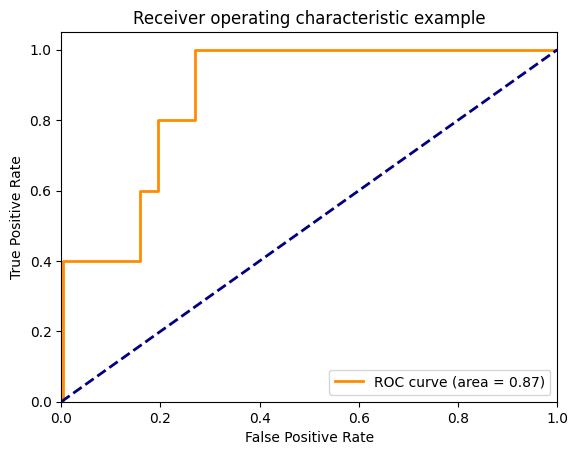

In [222]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = metrics.roc_curve(sub_dat['cancer_specific_mortality_cumulative'], sub_dat['CumHazard'])
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [223]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.0179000136664057


In [224]:
select = (data_test_exploded['survival_time_discrete'] == w) & pd.notna(data_test_exploded['cancer_specific_mortality_cumulative'])
sub_dat = data_test_exploded[select]
sub_X_test = sub_dat.drop(['survival_months', 'patient_id', 'bcr', 'mts',
                          'death_from_other_causes', 'cancer_specific_mortality',
                          'death_from_other_causes_discrete', 'mts_discrete',
                          'bcr_discrete', 'cancer_specific_mortality_discrete',
                             'cancer_specific_mortality_cumulative',
                             'death_from_other_causes_cumulative', 'mts_cumulative',
                             'bcr_cumulative', 'InstProb', 'CumHazard'], axis=1)
print(sub_X_test.columns)

Index(['age', 'psa', 'BxGleason', 'Rpgleson', 'clinical_stage_1',
       'clinical_stage_2', 'clinical_stage_3', 'biopsy_gleason_gg_1',
       'biopsy_gleason_gg_2', 'biopsy_gleason_gg_3', 'biopsy_gleason_gg_4',
       'biopsy_gleason_gg_5', 'pathological_gleason_gg_1',
       'pathological_gleason_gg_2', 'pathological_gleason_gg_3',
       'pathological_gleason_gg_4', 'pathological_gleason_gg_5',
       'pathologic_stage_0', 'pathologic_stage_1', 'pathologic_stage_2',
       'lni_0.0', 'lni_1.0', 'lni_unknown', 'surgical_margin_status_0',
       'surgical_margin_status_1', 'persistent_psa_0', 'persistent_psa_1',
       'DAmico_0', 'DAmico_1', 'DAmico_2', 'DAmico_3', 'TRYSgrupes_0',
       'TRYSgrupes_1', 'TRYSgrupes_2', 'PLNDO1_0', 'PLNDO1_1',
       'survival_time_discrete'],
      dtype='object')


In [234]:


temp_y_pred = (model.predict_proba(sub_X_test)[:,1] >= 0.018 ).astype(int)
#temp_y_pred = model.predict_proba(X_test)[:,1]

In [235]:
pd.Series(temp_y_pred).value_counts()

0    309
1      4
dtype: int64

In [236]:
print(confusion_matrix(sub_dat.cancer_specific_mortality_cumulative, temp_y_pred), '\n')
print(classification_report(sub_dat.cancer_specific_mortality_cumulative, temp_y_pred, zero_division=0), '\n')
print(roc_auc_score(sub_dat.cancer_specific_mortality_cumulative, model.predict_proba(sub_X_test)[:,1]))

[[306   2]
 [  3   2]] 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       308
           1       0.50      0.40      0.44         5

    accuracy                           0.98       313
   macro avg       0.75      0.70      0.72       313
weighted avg       0.98      0.98      0.98       313
 

0.874025974025974


In [25]:
# Define the model
model = LogisticRegression(solver='liblinear', random_state=0)

# Run the experiment
run_experiment(X_train.drop(['survival_months', 'patient_id'], axis=1), 
               X_test.drop(['survival_months', 'patient_id'], axis=1), 
               y_train.cancer_specific_mortality_discrete, 
               y_test.cancer_specific_mortality_discrete, 
               model)

Experiment with LogisticRegression:
	Starting fitting a LogisticRegression model...
	Finished fitting.
	Saving results to "results/cancer_specific_mortality_discrete/LogisticRegression"...
	Finished saving results.


In [28]:
# Example of reading experiment

model, experiment_info = read_experiment(model_name='LogisticRegression', 
                                         target_column='cancer_specific_mortality_discrete')

print(experiment_info)

{'model_name': 'LogisticRegression', 'confusion_matrix': {'train': array([[136965,      0],
       [    36,      0]], dtype=int64), 'test': array([[33142,     0],
       [   14,     0]], dtype=int64)}, 'classification_report': {'train': {'0': {'precision': 0.9997372281954147, 'recall': 1.0, 'f1-score': 0.9998685968331837, 'support': 136965}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 36}, 'accuracy': 0.9997372281954147, 'macro avg': {'precision': 0.49986861409770733, 'recall': 0.5, 'f1-score': 0.49993429841659187, 'support': 137001}, 'weighted avg': {'precision': 0.9994745254398507, 'recall': 0.9997372281954147, 'f1-score': 0.9996058595576456, 'support': 137001}}, 'test': {'0': {'precision': 0.9995777536494149, 'recall': 1.0, 'f1-score': 0.9997888322423, 'support': 33142}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14}, 'accuracy': 0.9995777536494149, 'macro avg': {'precision': 0.49978887682470746, 'recall': 0.5, 'f1-score': 0.49989441612

In [7]:
data_path = 'Data/persistentpsa_3.sas7bdat'
df = pd.read_sas(data_path)
print(df.head())
df.to_excel('saved_file.xlsx')

         Kodas                              Pavarde        As_kodas  Amzius  \
0  b'2009.121'        b'Mickevi\xc4\x8dius Albinas'  b'33703201737'    72.0   
1  b'2011.160'  b'U\xc5\xbdEMECKIS, JONAS VYTAUTAS'  b'34504130345'    66.0   
2  b'2012.151'                  b'Stepanov Nikolaj'  b'34709240225'    65.0   
3   b'2015.34'              b'Dzenkauskas Gintaras'  b'34501260052'    70.0   
4   b'2018.66'                     b'Orlov Genadij'  b'36104240960'    57.0   

     PSA     cT  naujasCT   Gleason1  BxGleason  Bxkodas  ...  Stebej_men  \
0  12.70  b'2,'       2.0  b'7(3+4)'        7.0      2.0  ...     b'108,'   
1   7.59  b'3a'       3.0     b'4+5'        9.0      5.0  ...      b'60,'   
2   7.60  b'3a'       3.0  b'7/3+4/'        7.0      2.0  ...      b'52,'   
3  14.18  b'3a'       3.0     b'4+3'        7.0      3.0  ...      b'29,'   
4   7.86  b'2,'       2.0     b'4+3'        7.0      3.0  ...      b'31,'   

     BFS  MTS  MTS_men SURVIVAL   OS  CSS  TEIG_STULP  STULP_S

In [28]:
!python --version

Python 3.10.4


In [31]:
!jupyter-notebook --version

'jupyter-notebook' is not recognized as an internal or external command,
operable program or batch file.
